### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

#### Config parameters

In [2]:
random_state = 3    # to reproduce the results.

### Exploratory Analysis

In [3]:
df = pd.read_csv("data.csv", index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 863 entries, 0 to 862
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   location      863 non-null    int64  
 1   country       863 non-null    int64  
 2   gender        863 non-null    int64  
 3   age           863 non-null    float64
 4   vis_wuhan     863 non-null    int64  
 5   from_wuhan    863 non-null    int64  
 6   symptom1      863 non-null    int64  
 7   symptom2      863 non-null    int64  
 8   symptom3      863 non-null    int64  
 9   symptom4      863 non-null    int64  
 10  symptom5      863 non-null    int64  
 11  symptom6      863 non-null    int64  
 12  diff_sym_hos  863 non-null    int64  
 13  result        863 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 101.1 KB


The data doesn't have null or incomplete samples.

In [4]:
df.head()

,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
0,104,8,1,66.0,1,0,14,31,19,12,3,1,8,1
1,101,8,0,56.0,0,1,14,31,19,12,3,1,0,0
2,137,8,1,46.0,0,1,14,31,19,12,3,1,13,0
3,116,8,0,60.0,1,0,14,31,19,12,3,1,0,0
4,116,8,1,58.0,0,0,14,31,19,12,3,1,0,0


#### Quantitative properties

In [5]:
quan_cols = ["age", "diff_sym_hos"]
df[quan_cols].describe()

,age,diff_sym_hos
count,863.000000,863.000000
mean,49.400000,0.995365
std,15.079203,2.358767
min,2.000000,-5.000000
25%,40.000000,0.000000
50%,49.400000,0.000000
75%,57.000000,1.000000
max,96.000000,15.000000


It appears that the patients are relatively old (mean of 49.) The median is 49, which makes the mean a good indicator.

Let's see how correlated is the age to the result.

In [6]:
df.groupby("result")["age"].describe()

,count,mean,std,min,25%,50%,75%,max
result,,,,,,,,
0,755.0,46.463841,12.820090,2.0,38.0,49.4,55.0,81.0
1,108.0,69.925926,13.695421,8.0,65.0,72.5,76.0,96.0


0         AxesSubplot(0.1,0.15;0.363636x0.75)
1    AxesSubplot(0.536364,0.15;0.363636x0.75)
dtype: object

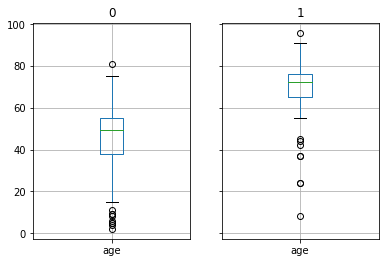

In [7]:
df.groupby("result").boxplot(column="age")

The mean age of the deceased patients is nearly 70 while the recoverd ones have a mean age of 46.46. Thus, the age is positively correlated with mortality rate.

Let's take a look at *diff_sym_hos* (time before symptoms appear.)

0         AxesSubplot(0.1,0.15;0.363636x0.75)
1    AxesSubplot(0.536364,0.15;0.363636x0.75)
dtype: object

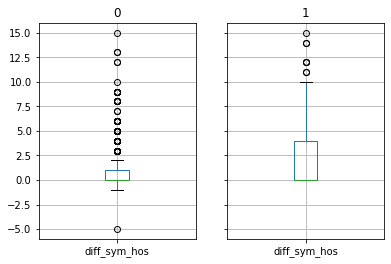

In [8]:
df.groupby("result").boxplot(column="diff_sym_hos")

Cannot decide on a clear relationship.

#### Qualitative properties

In [9]:
symptom_cols = [f"symptom{i}" for i in range(1, 7)]
qual_cols = ["location", "gender", "vis_wuhan", "from_wuhan", *symptom_cols, "result"]

Let's have a look at whether visiting Wuhan has any relation with mortality rate.

In [10]:
df.groupby("result")["vis_wuhan"].value_counts(normalize=True)

result  vis_wuhan
0       0            0.796026
        1            0.203974
1       0            0.972222
        1            0.027778
Name: vis_wuhan, dtype: float64

<AxesSubplot:ylabel='result'>

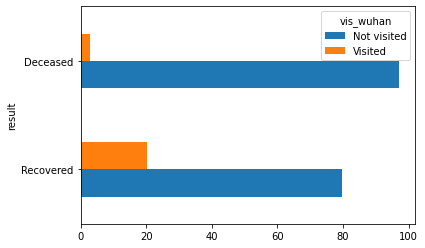

In [11]:
(df.groupby("result")["vis_wuhan"].value_counts(normalize=True) * 100).unstack() \
    .rename(columns={0: "Not visited", 1: "Visited"}, index={0: "Recovered", 1: "Deceased"}).plot.barh()

Contrary to stereotypes, most of the deceased didn't visit Wuhan (97%) while 20% of the recovered did actually visit Wuhan.

Let's see the relation between gender and mortality rate.

In [12]:
df.groupby("result")["gender"].value_counts(normalize=True)

result  gender
0       1         0.423841
        0         0.354967
        2         0.221192
1       1         0.638889
        0         0.314815
        2         0.046296
Name: gender, dtype: float64

<AxesSubplot:ylabel='result'>

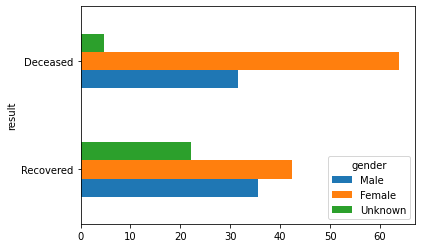

In [13]:
(df.groupby("result")["gender"].value_counts(normalize=True) * 100).unstack() \
    .rename(columns={0: "Male", 1: "Female", 2: "Unknown"}, index={0: "Recovered", 1: "Deceased"}).plot.barh()

Surprisingly, a considrable group of the deceased are females (63%) while only 42% of the recovered are females.
This suggests a correlation between females and mortality rate.

It's time to investigate the symptoms, which are expected to be highly correlated with the mortality rate.

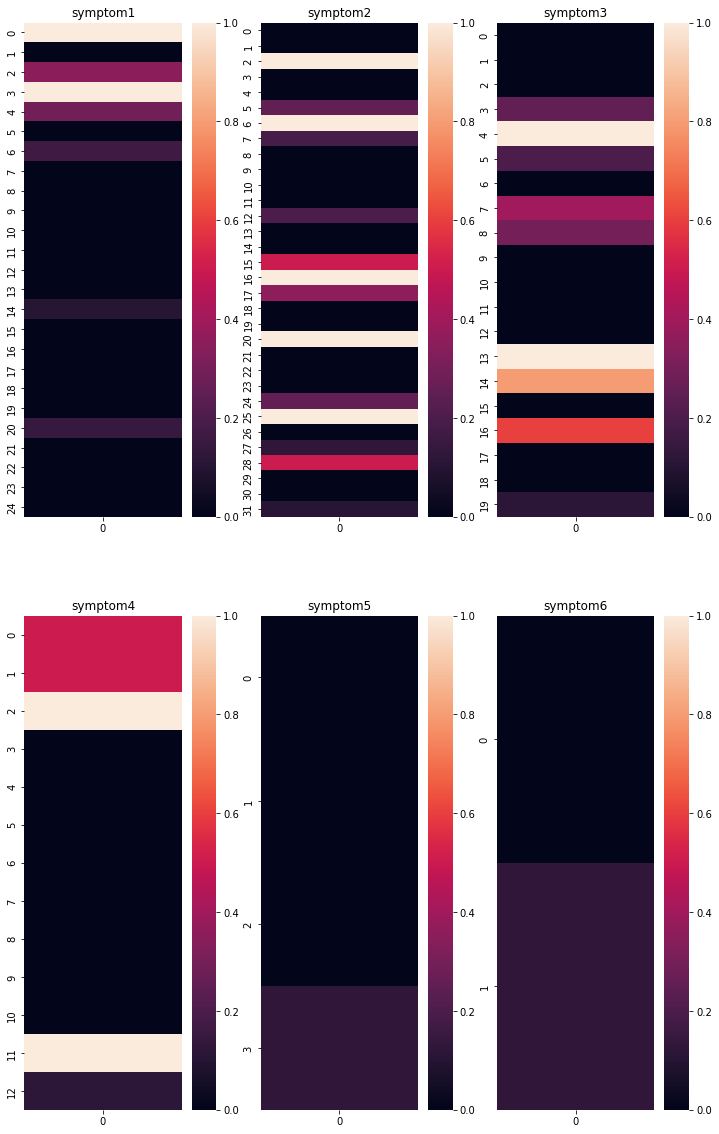

In [14]:
f, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 20))
for i, col in enumerate(symptom_cols):
    ax = axes[int(i/3)][int(i%3)]
    sns.heatmap(df[[col, "result"]].groupby(col).agg({"result": "mean"}).values, vmin=0, vmax=1, ax=ax)
    ax.set_title(col)
    
plt.show()

### Preparing and Splitting Data

Split the data containing specific features. Defaults to all features available in the dataset.

In [15]:
def split_data(features: list = df.columns.values[:-1], normalize: bool = True):
    global X_train, y_train, X_valid, X_test, y_valid, y_test
    df_temp = df
    if normalize:
        scaler = MinMaxScaler()
        df_temp = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)                                    # Normalize the numerical features
    X, y = df_temp[features].values[:,:], df_temp.values[:,-1]                                                  # As numpy arrays
    X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8, random_state=random_state)          # Training data
    X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5, random_state=random_state)  # Validation and Testing data

Utility function for scoring models.

In [16]:
def score(truth: list, pred: list):
    acc, pre, rec, f1 = accuracy_score(truth, pred), precision_score(truth, pred), recall_score(truth, pred), f1_score(truth, pred)
    
    print("Accuracy  : %.2f." % acc)
    print("Precision : %.2f." % pre)
    print("Recall    : %.2f." % rec)
    print("F1-Score  : %.2f." % f1)

### Learning and Testing

#### KNN

Hyperparameters

In [76]:
k_neighbors = 5

Training

In [77]:
features = ["age", *symptom_cols]
split_data(features=features, normalize=True)

In [82]:
def pick_k(min: int = 1, maxnum: int = 10, visualize=False):
    min = min if (min % 2 == 1) else (min + 1)
    acc = {}
    for k in range(min, maxnum, 2):
        classifier = KNeighborsClassifier(n_neighbors = k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_valid)
        acc[k]= accuracy_score(y_valid, y_pred)
    print(acc)
    if visualize:
        sns.lineplot(x=acc.keys(), y=acc.values())
        plt.title("Accuracy vs. K")
        plt.xlabel("K neighbours")
        plt.ylabel("Accuracy")
       
    return max(acc,key= lambda x : acc[x]) 

# Plotting multidimensional data each 2 features labeled separately

7


C:\Users\omark\AppData\Local\Temp/ipykernel_11152/2774533875.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 432x288 with 0 Axes>

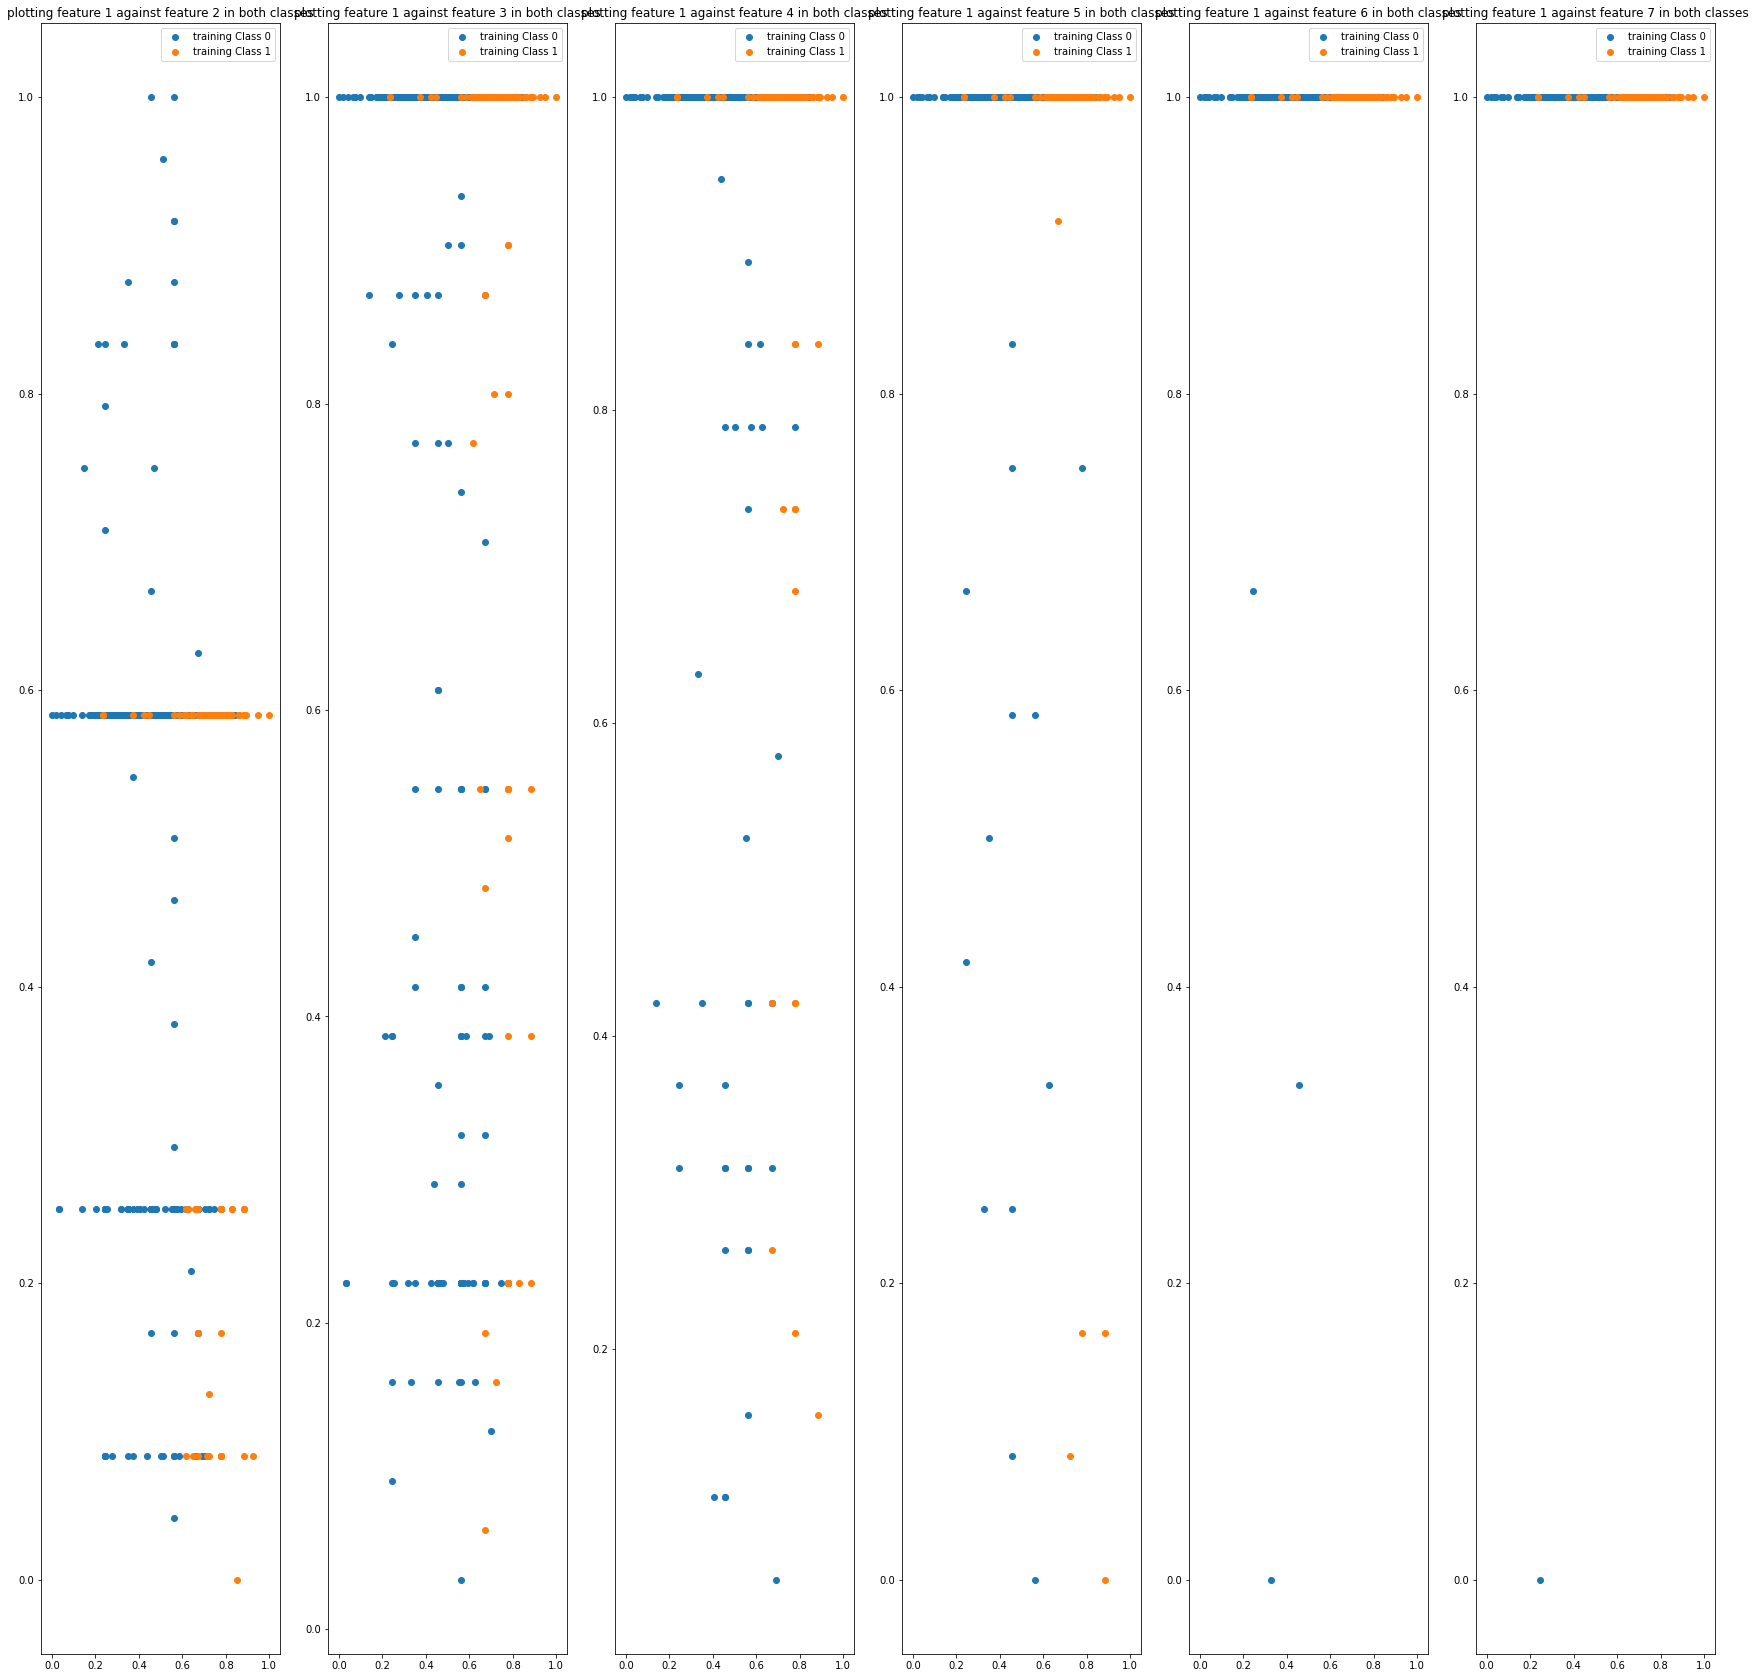

<Figure size 432x288 with 0 Axes>

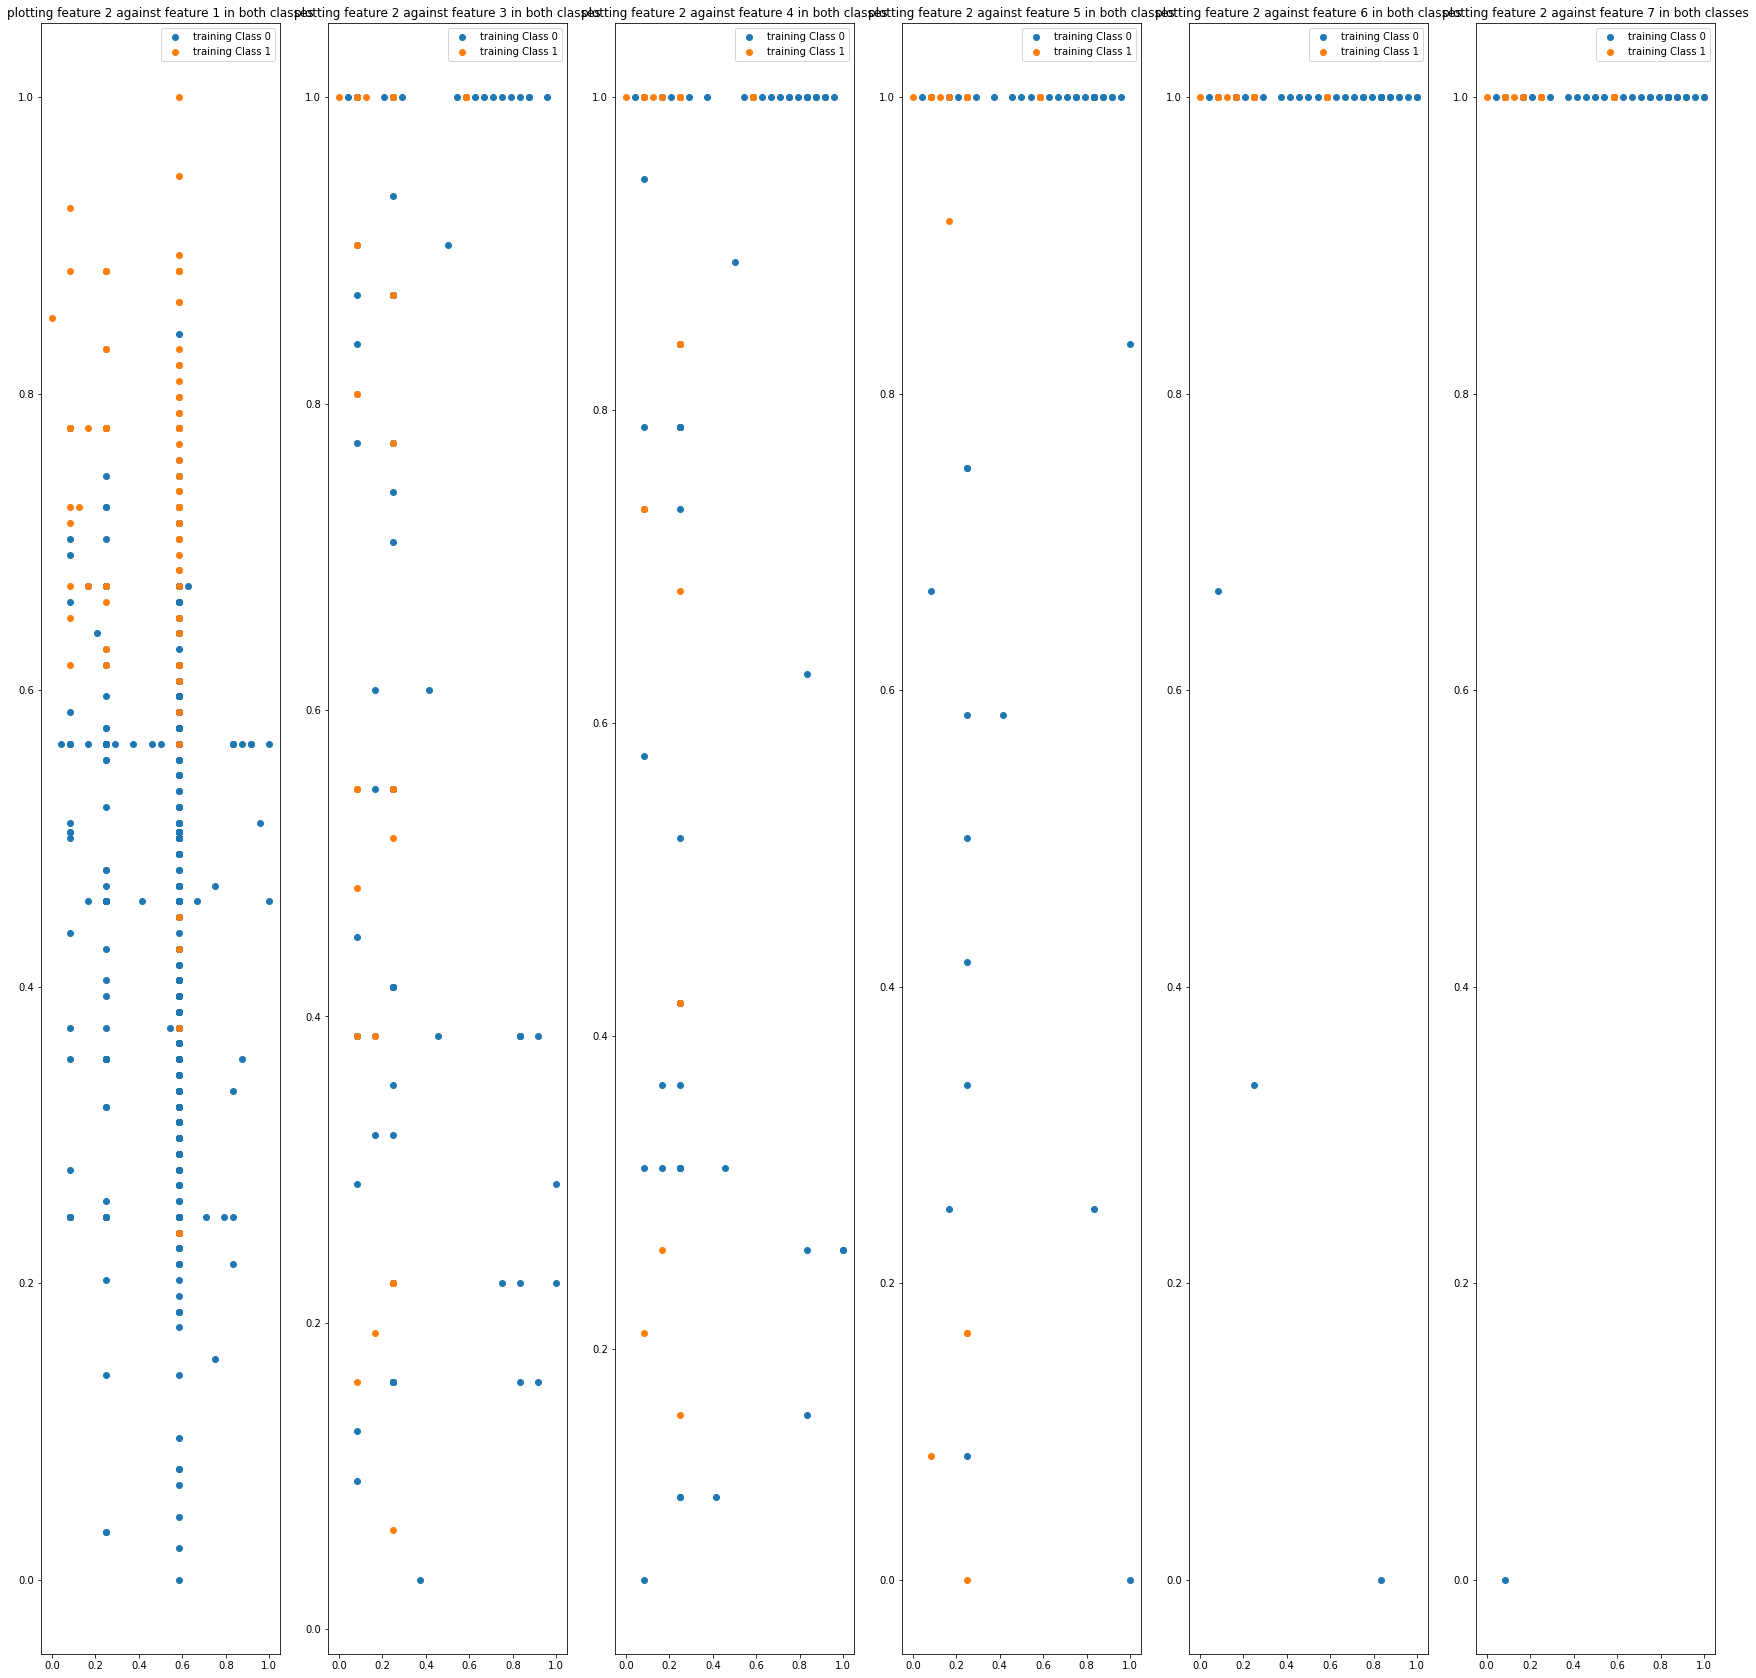

<Figure size 432x288 with 0 Axes>

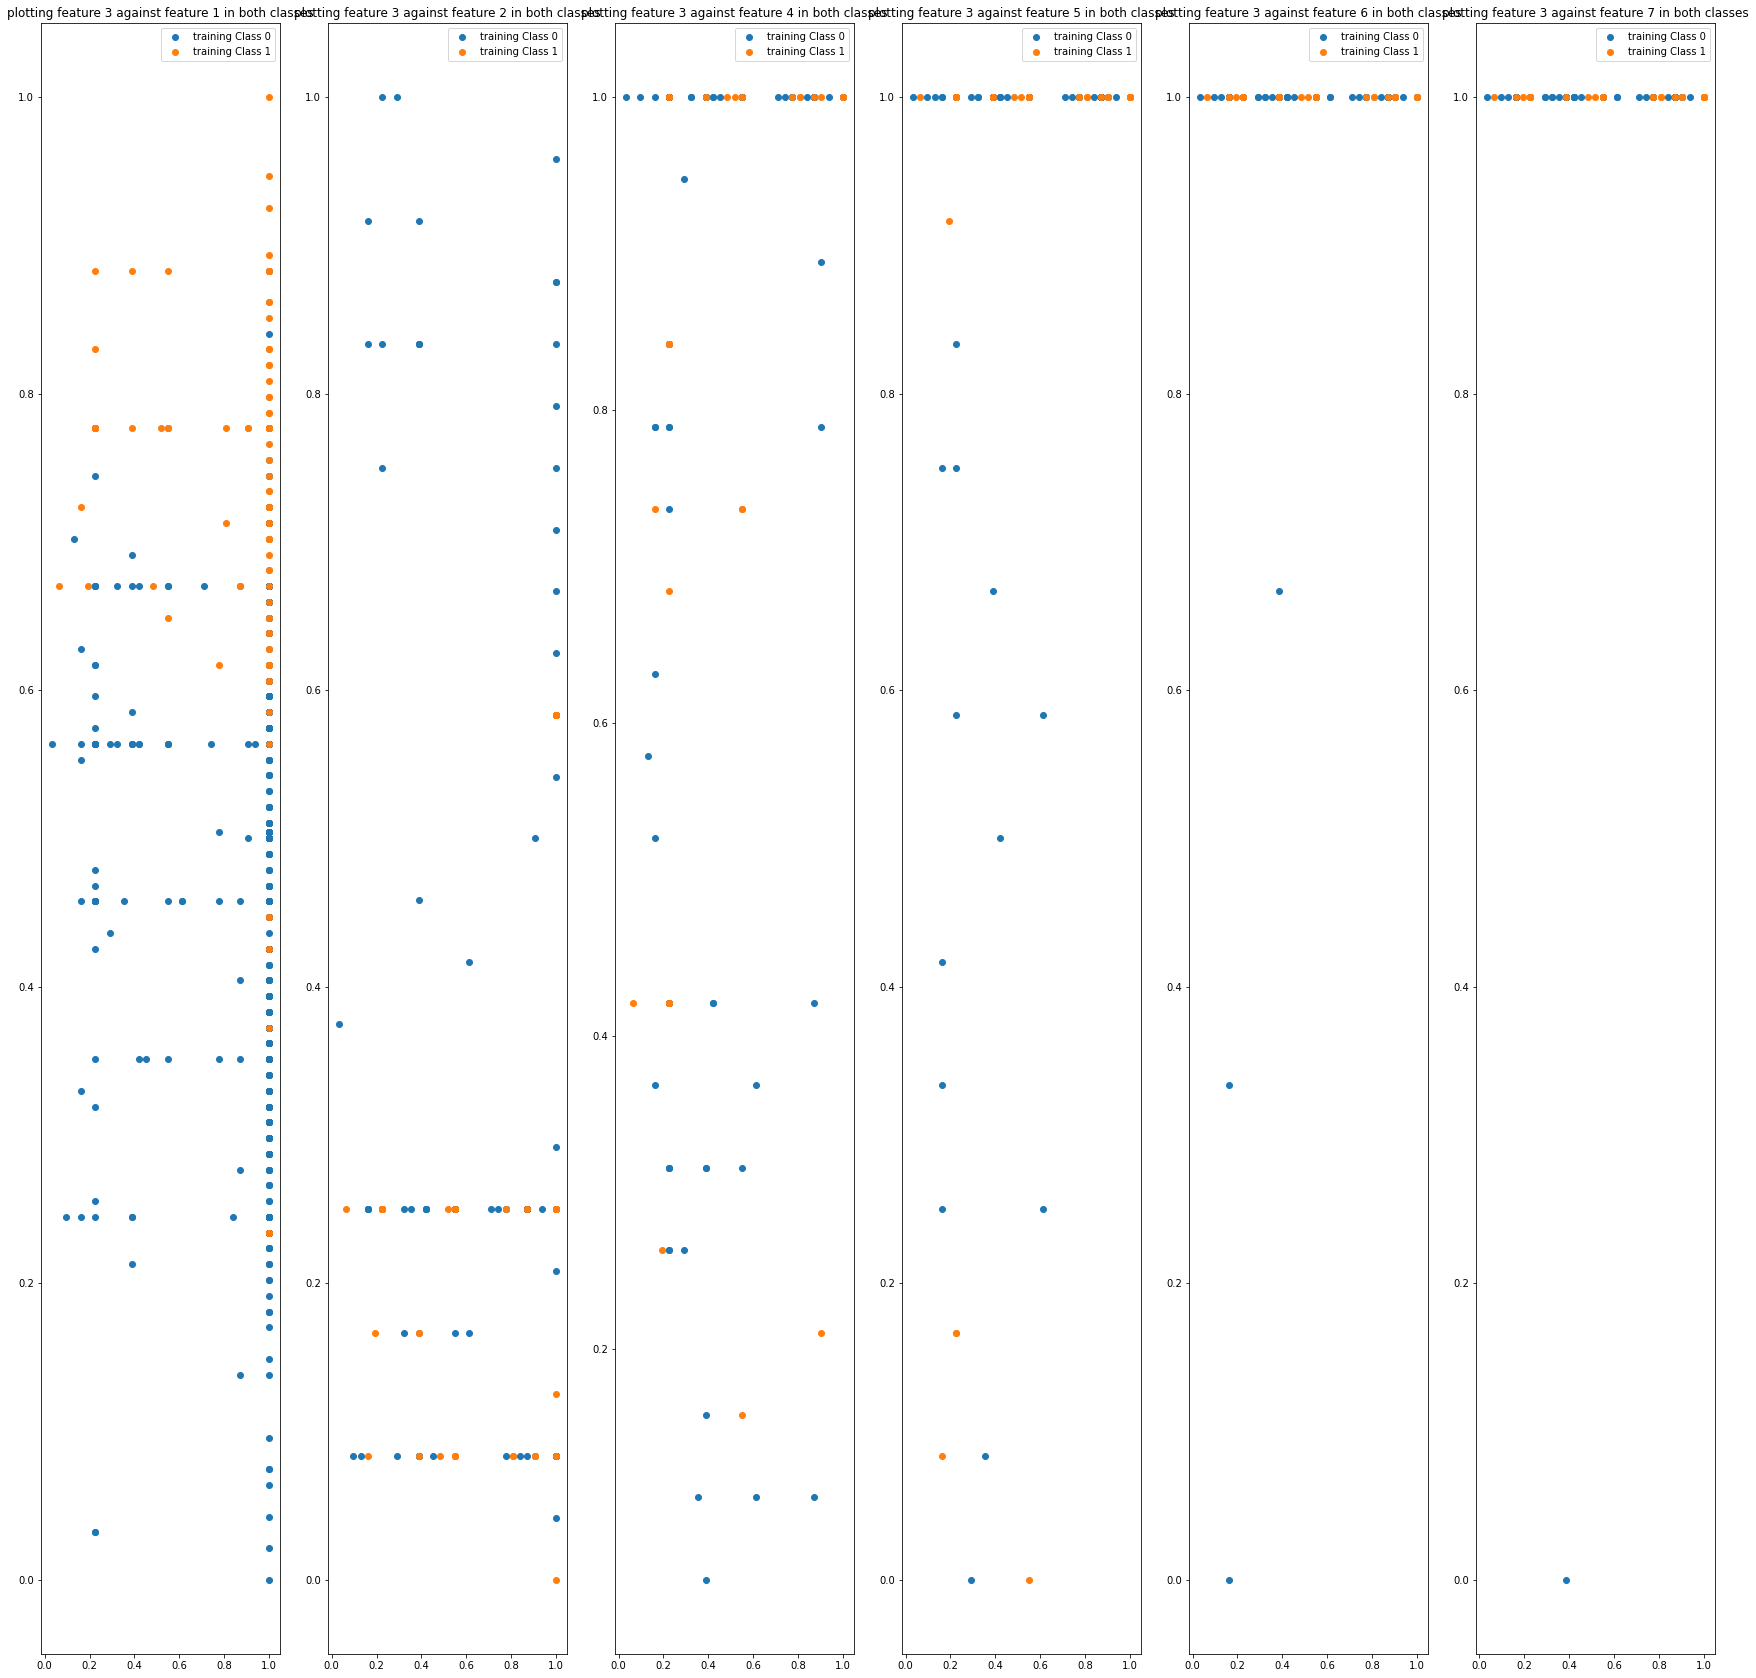

<Figure size 432x288 with 0 Axes>

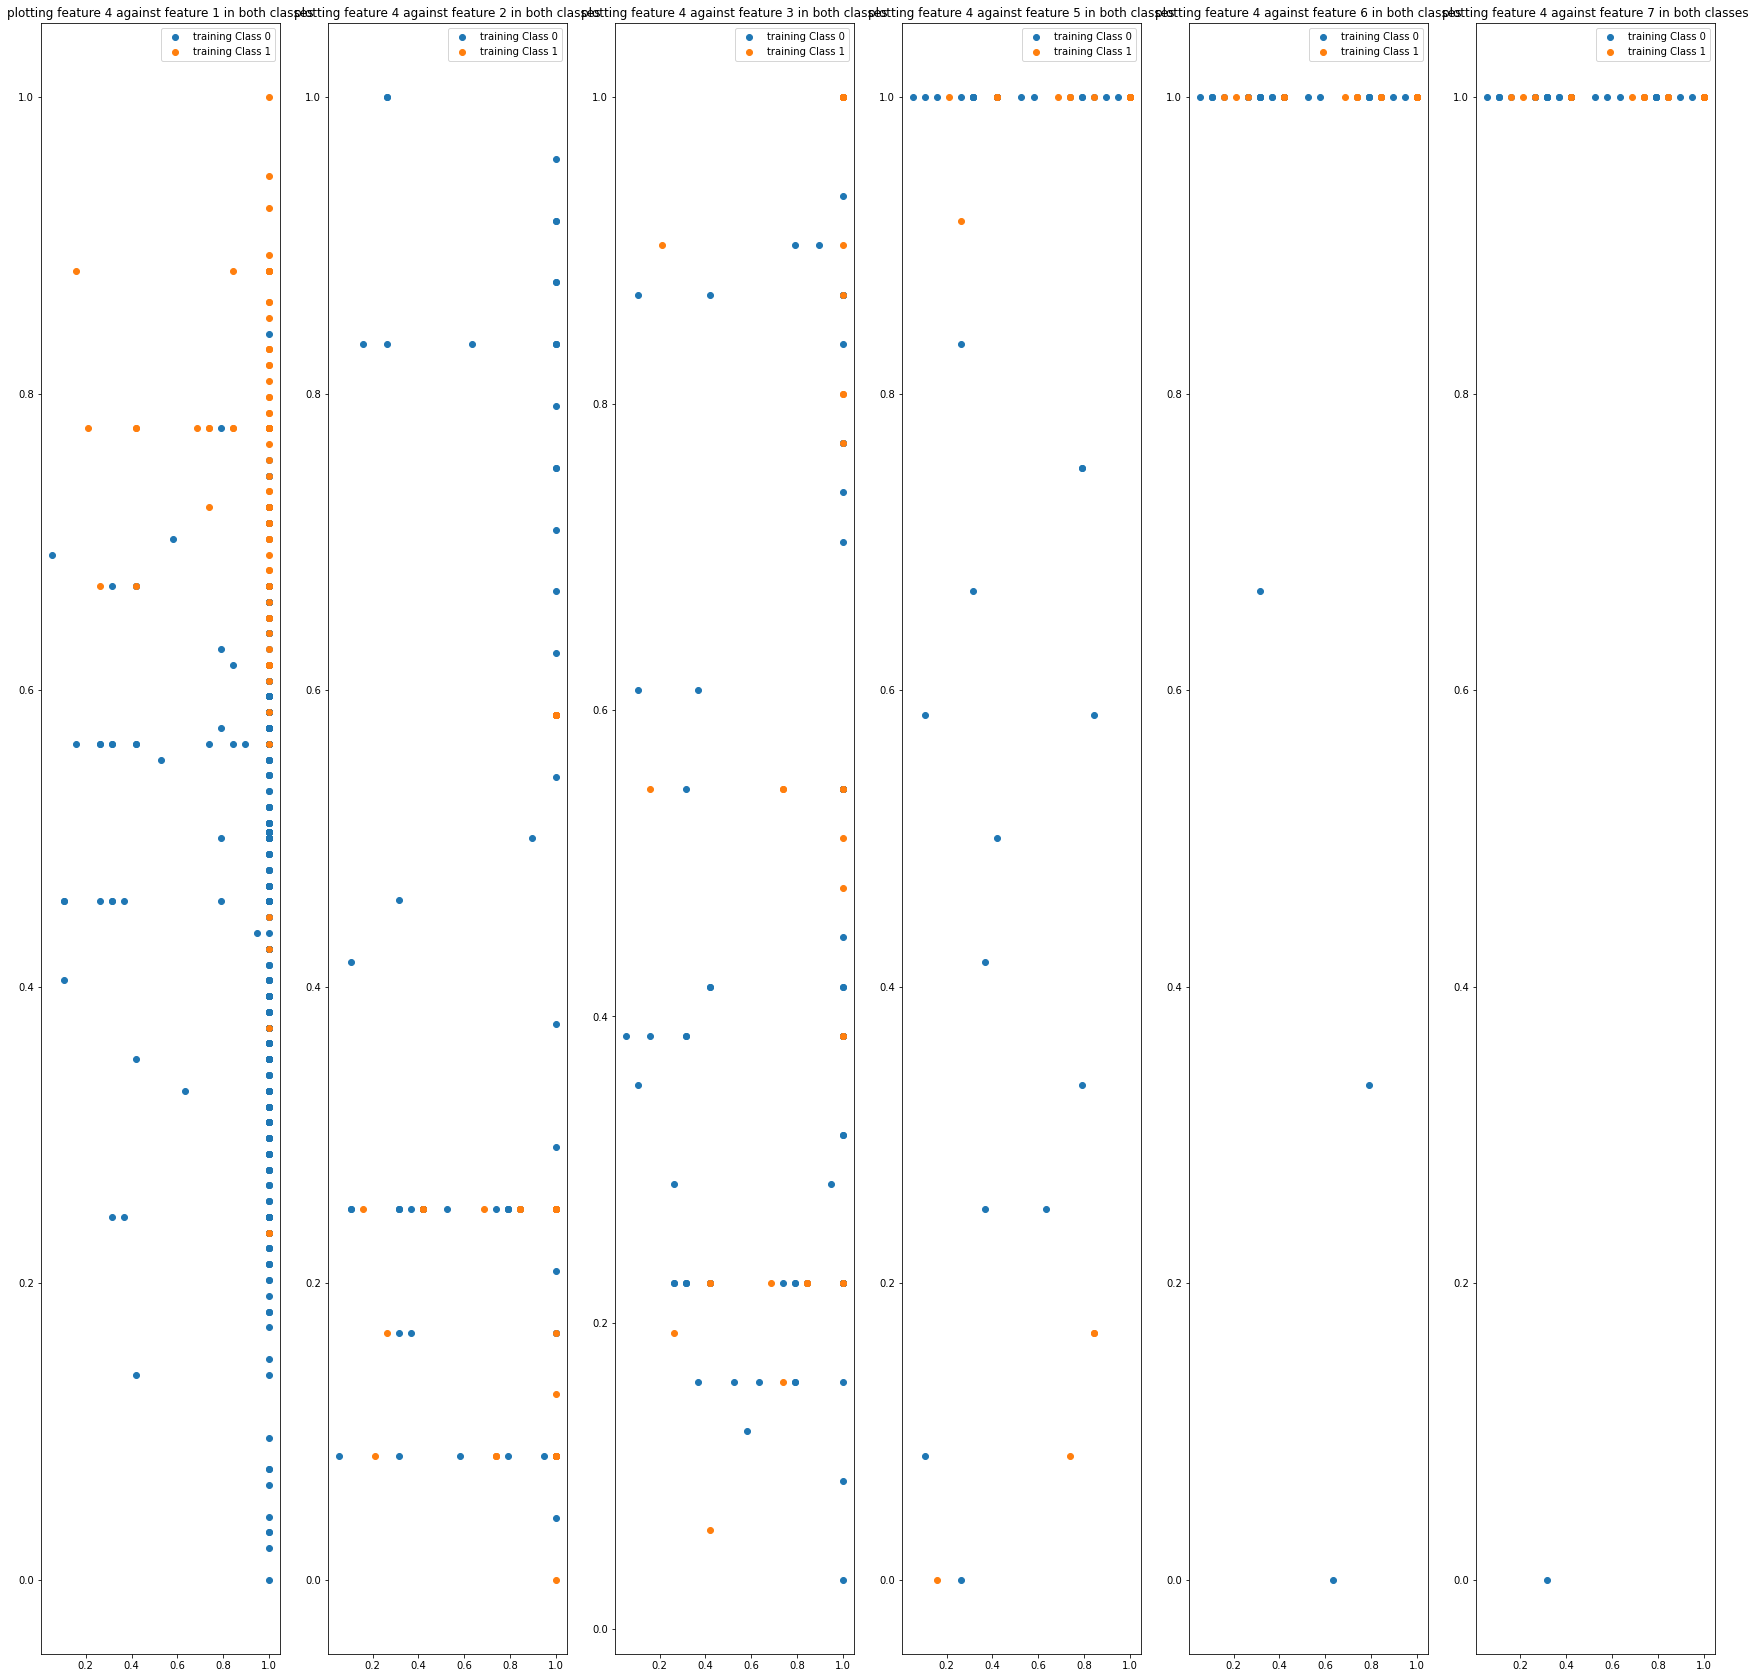

<Figure size 432x288 with 0 Axes>

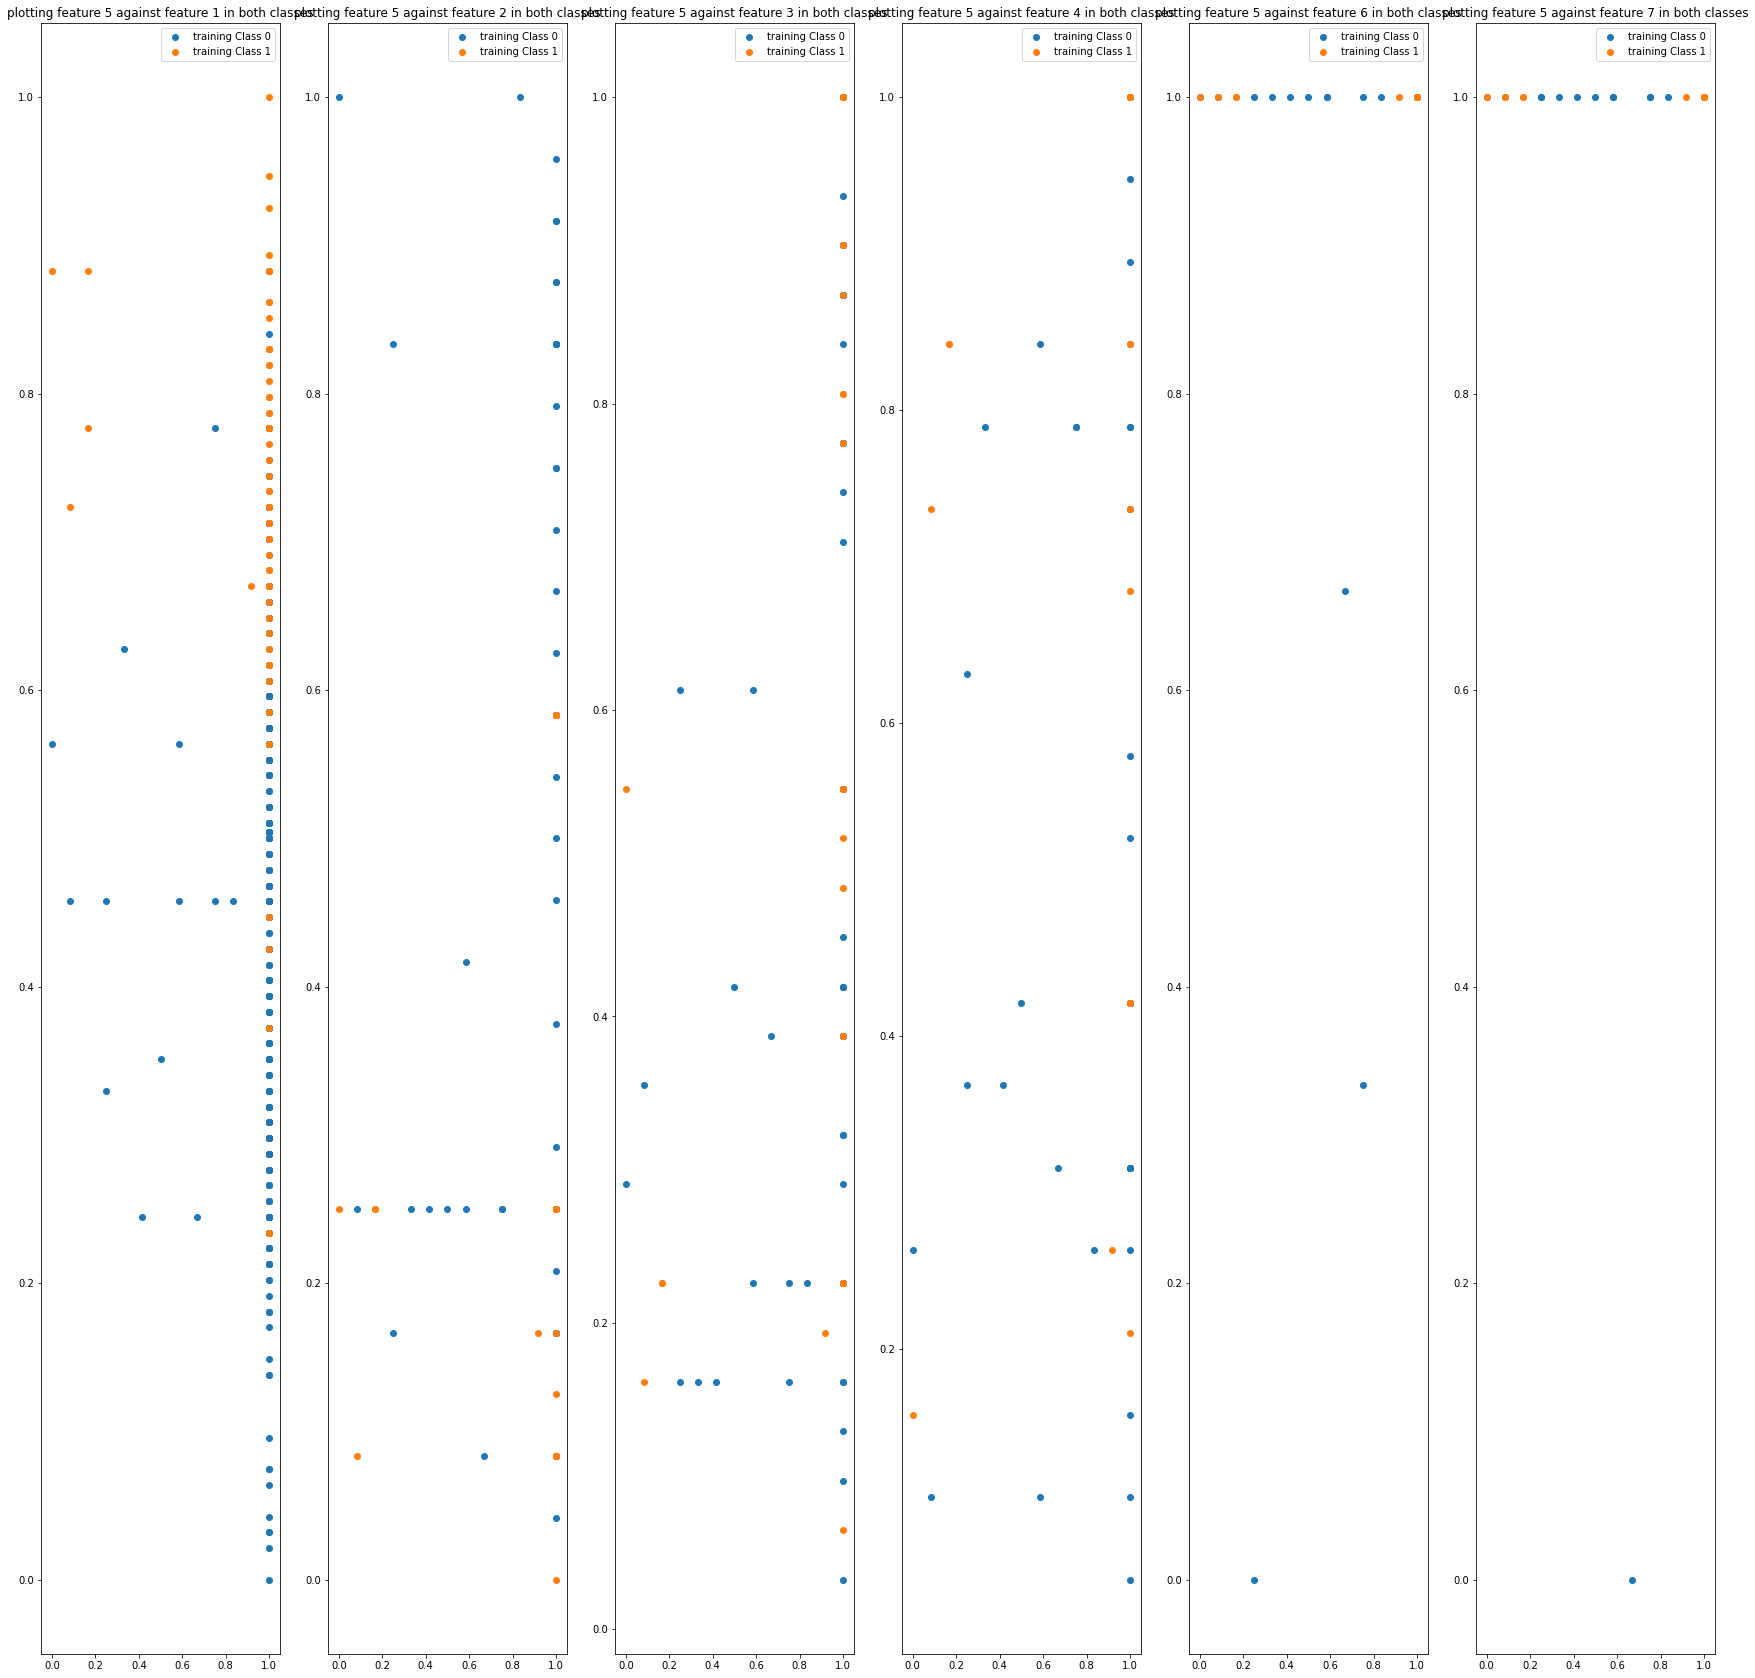

<Figure size 432x288 with 0 Axes>

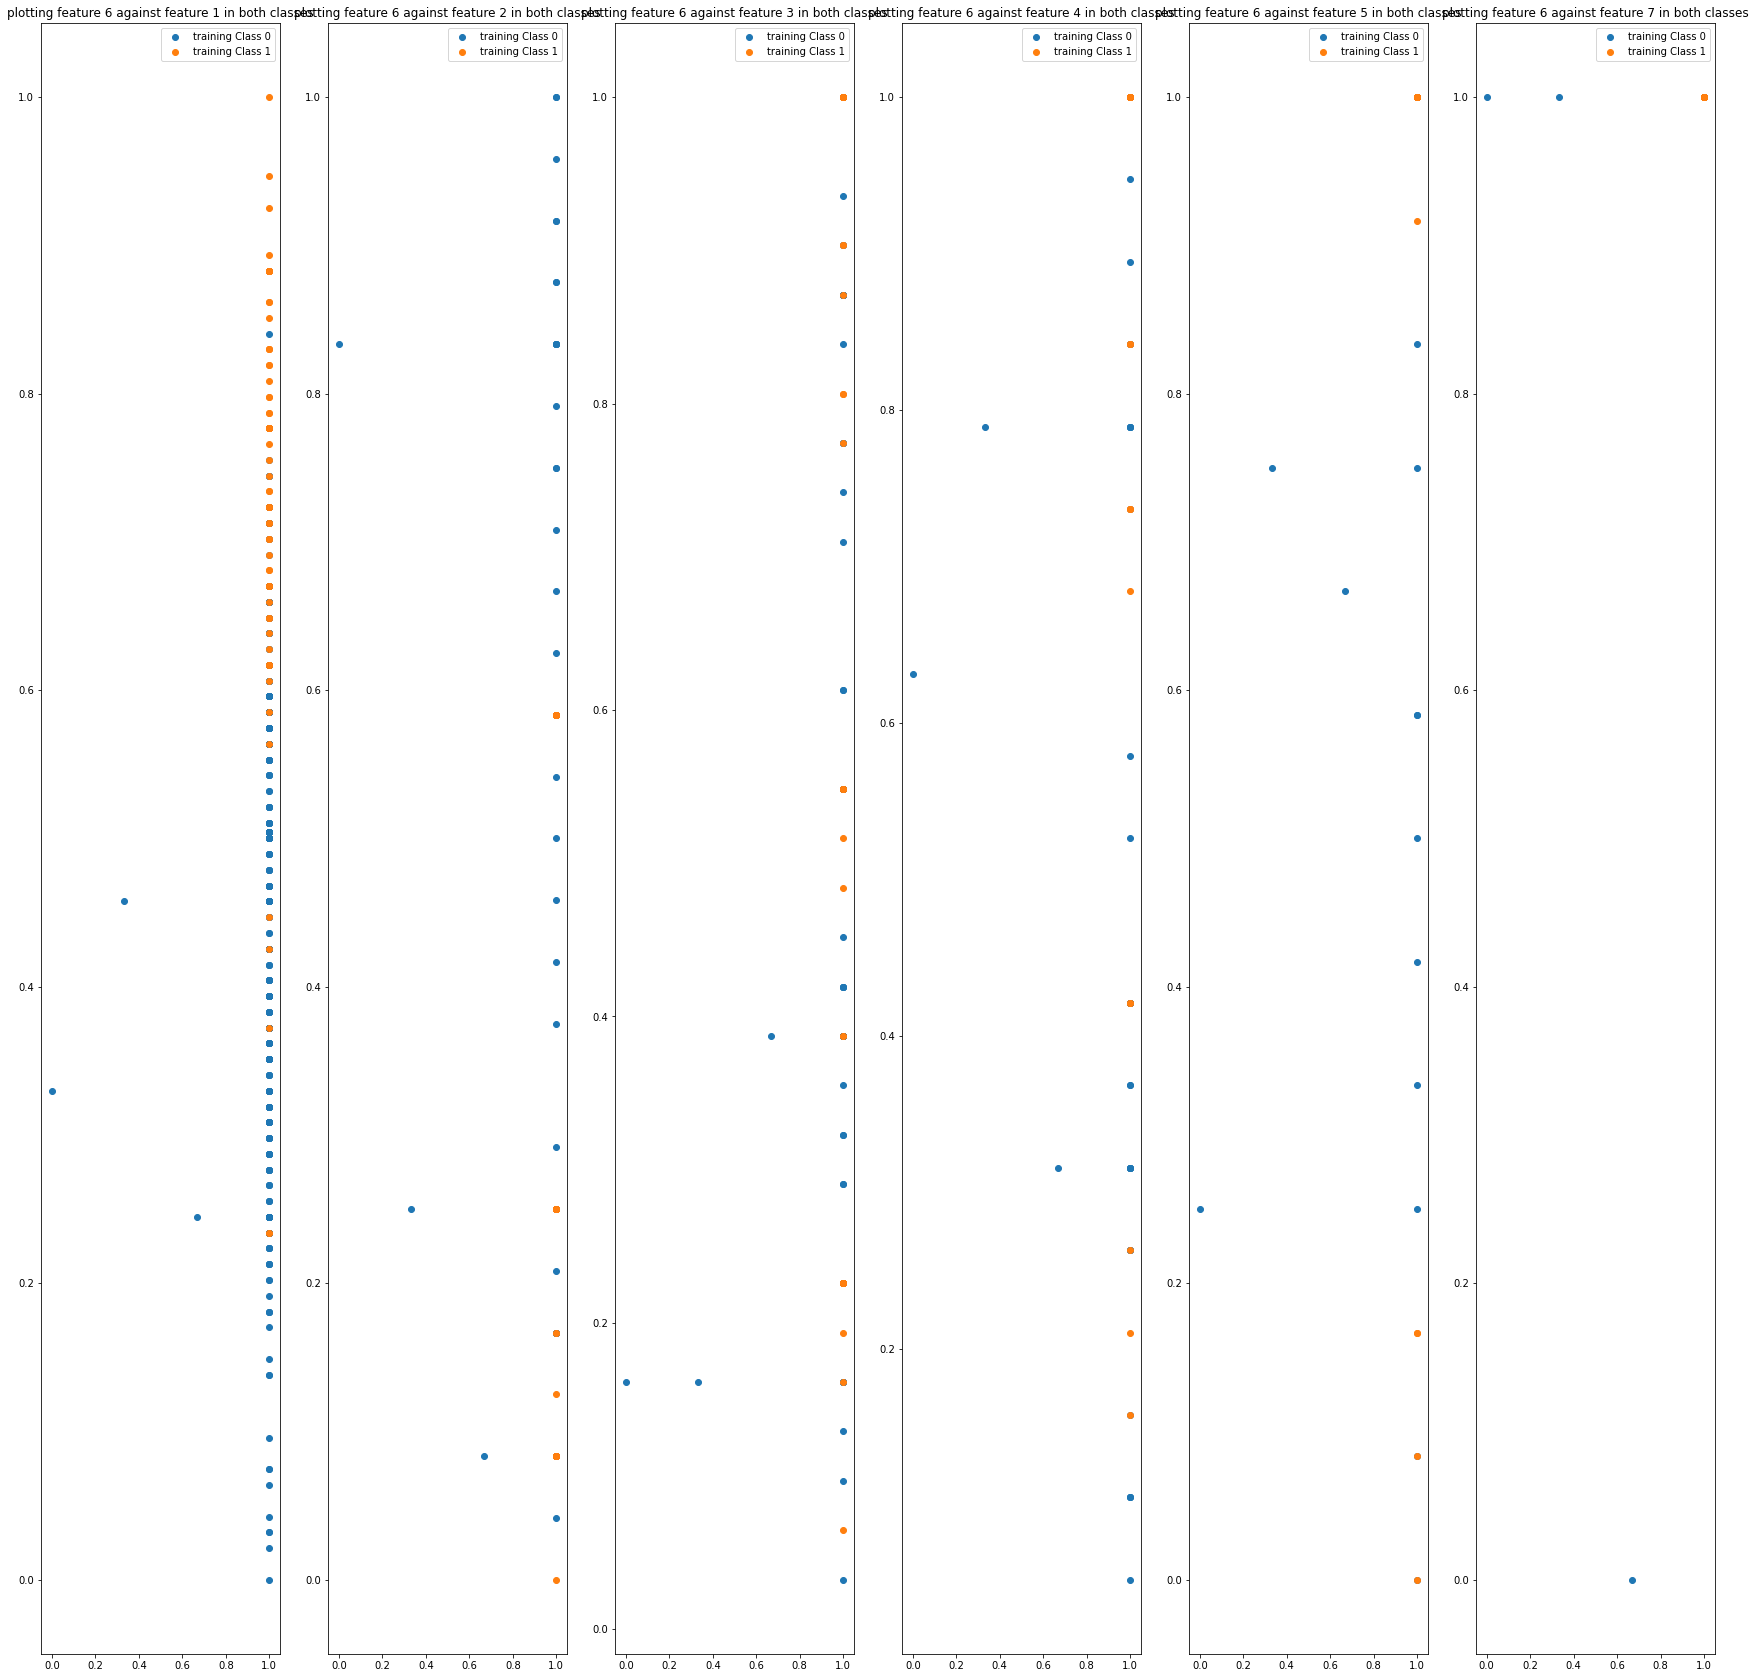

In [20]:

def scatter_plot_multidimensional_data(X, Y, prefix=''): 
    #print(X.shape)
    #print(Y.shape) 
    numclasses=int(Y.max())
    numrows,numfeatures=X.shape
    print(numfeatures)
    ##passive aggressive way for plotting each 2 features showing all dimensions of the data based on class label in training 
    for featurenum in range(numfeatures-1):
        fig=plt.figure()
        fig,axes=plt.subplots(nrows=1,ncols=numfeatures-1,sharex=True,sharey=False,figsize=(30,30))
        #print(X[j])
        #print(featurenum)
        c=0
        for j in range(numfeatures):
            if j !=featurenum:
                for classnum in range(numclasses+1):
                    axes[c].title.set_text("plotting feature {} against feature {} in both classes".format(featurenum+1,j+1))
                    Xlist=list()
                    X2List=list()
                    for row in range(numrows):
                        if Y[row]==classnum:
                            #print(X[row][featurenum])
                            Xlist.append(X[row][featurenum])
                            X2List.append(X[row][j])
                    axes[c].scatter(Xlist, X2List, label='{} Class {}'.format(prefix,classnum))
                axes[c].legend()
                c+=1
            fig.show()
scatter_plot_multidimensional_data(X_train,y_train,'training')


{1: 0.9069767441860465, 3: 0.9302325581395349, 5: 0.9418604651162791, 7: 0.9534883720930233, 9: 0.9534883720930233, 11: 0.9418604651162791, 13: 0.9302325581395349}


C:\Users\omark\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


7

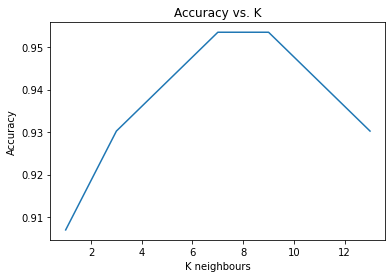

In [21]:
k_neighbors = pick_k(min=1, maxnum=15, visualize=True)
k_neighbors

In [22]:
classifier = KNeighborsClassifier(n_neighbors = k_neighbors)

In [23]:
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7)

Testing

Accuracy  : 0.85.
Precision : 0.22.
Recall    : 0.25.
F1-Score  : 0.24.


<Figure size 432x288 with 0 Axes>

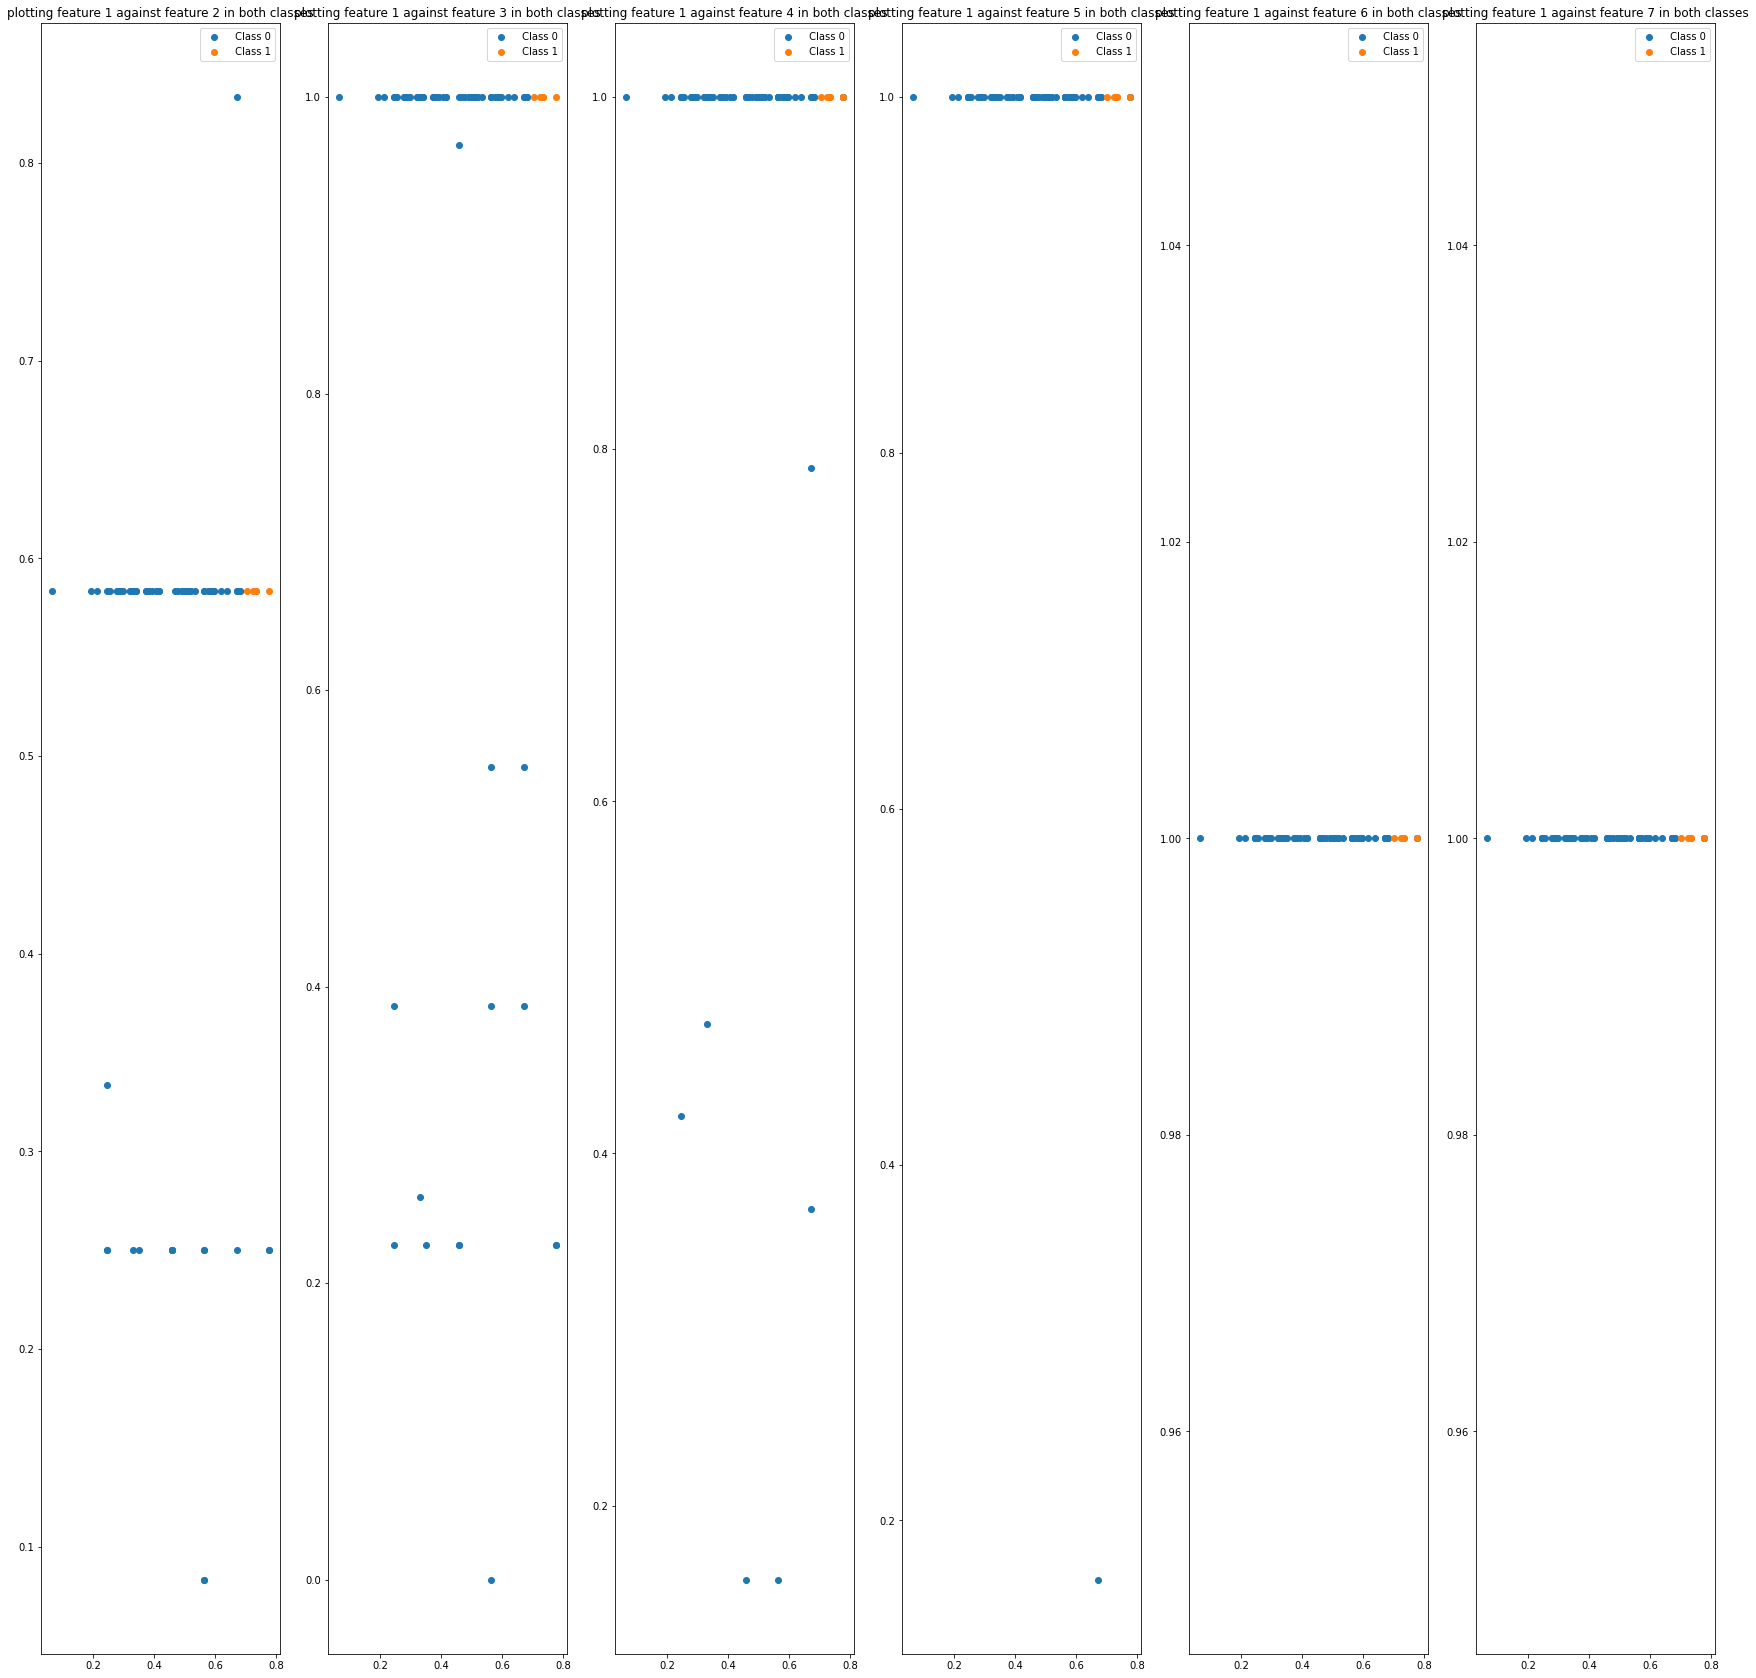

<Figure size 432x288 with 0 Axes>

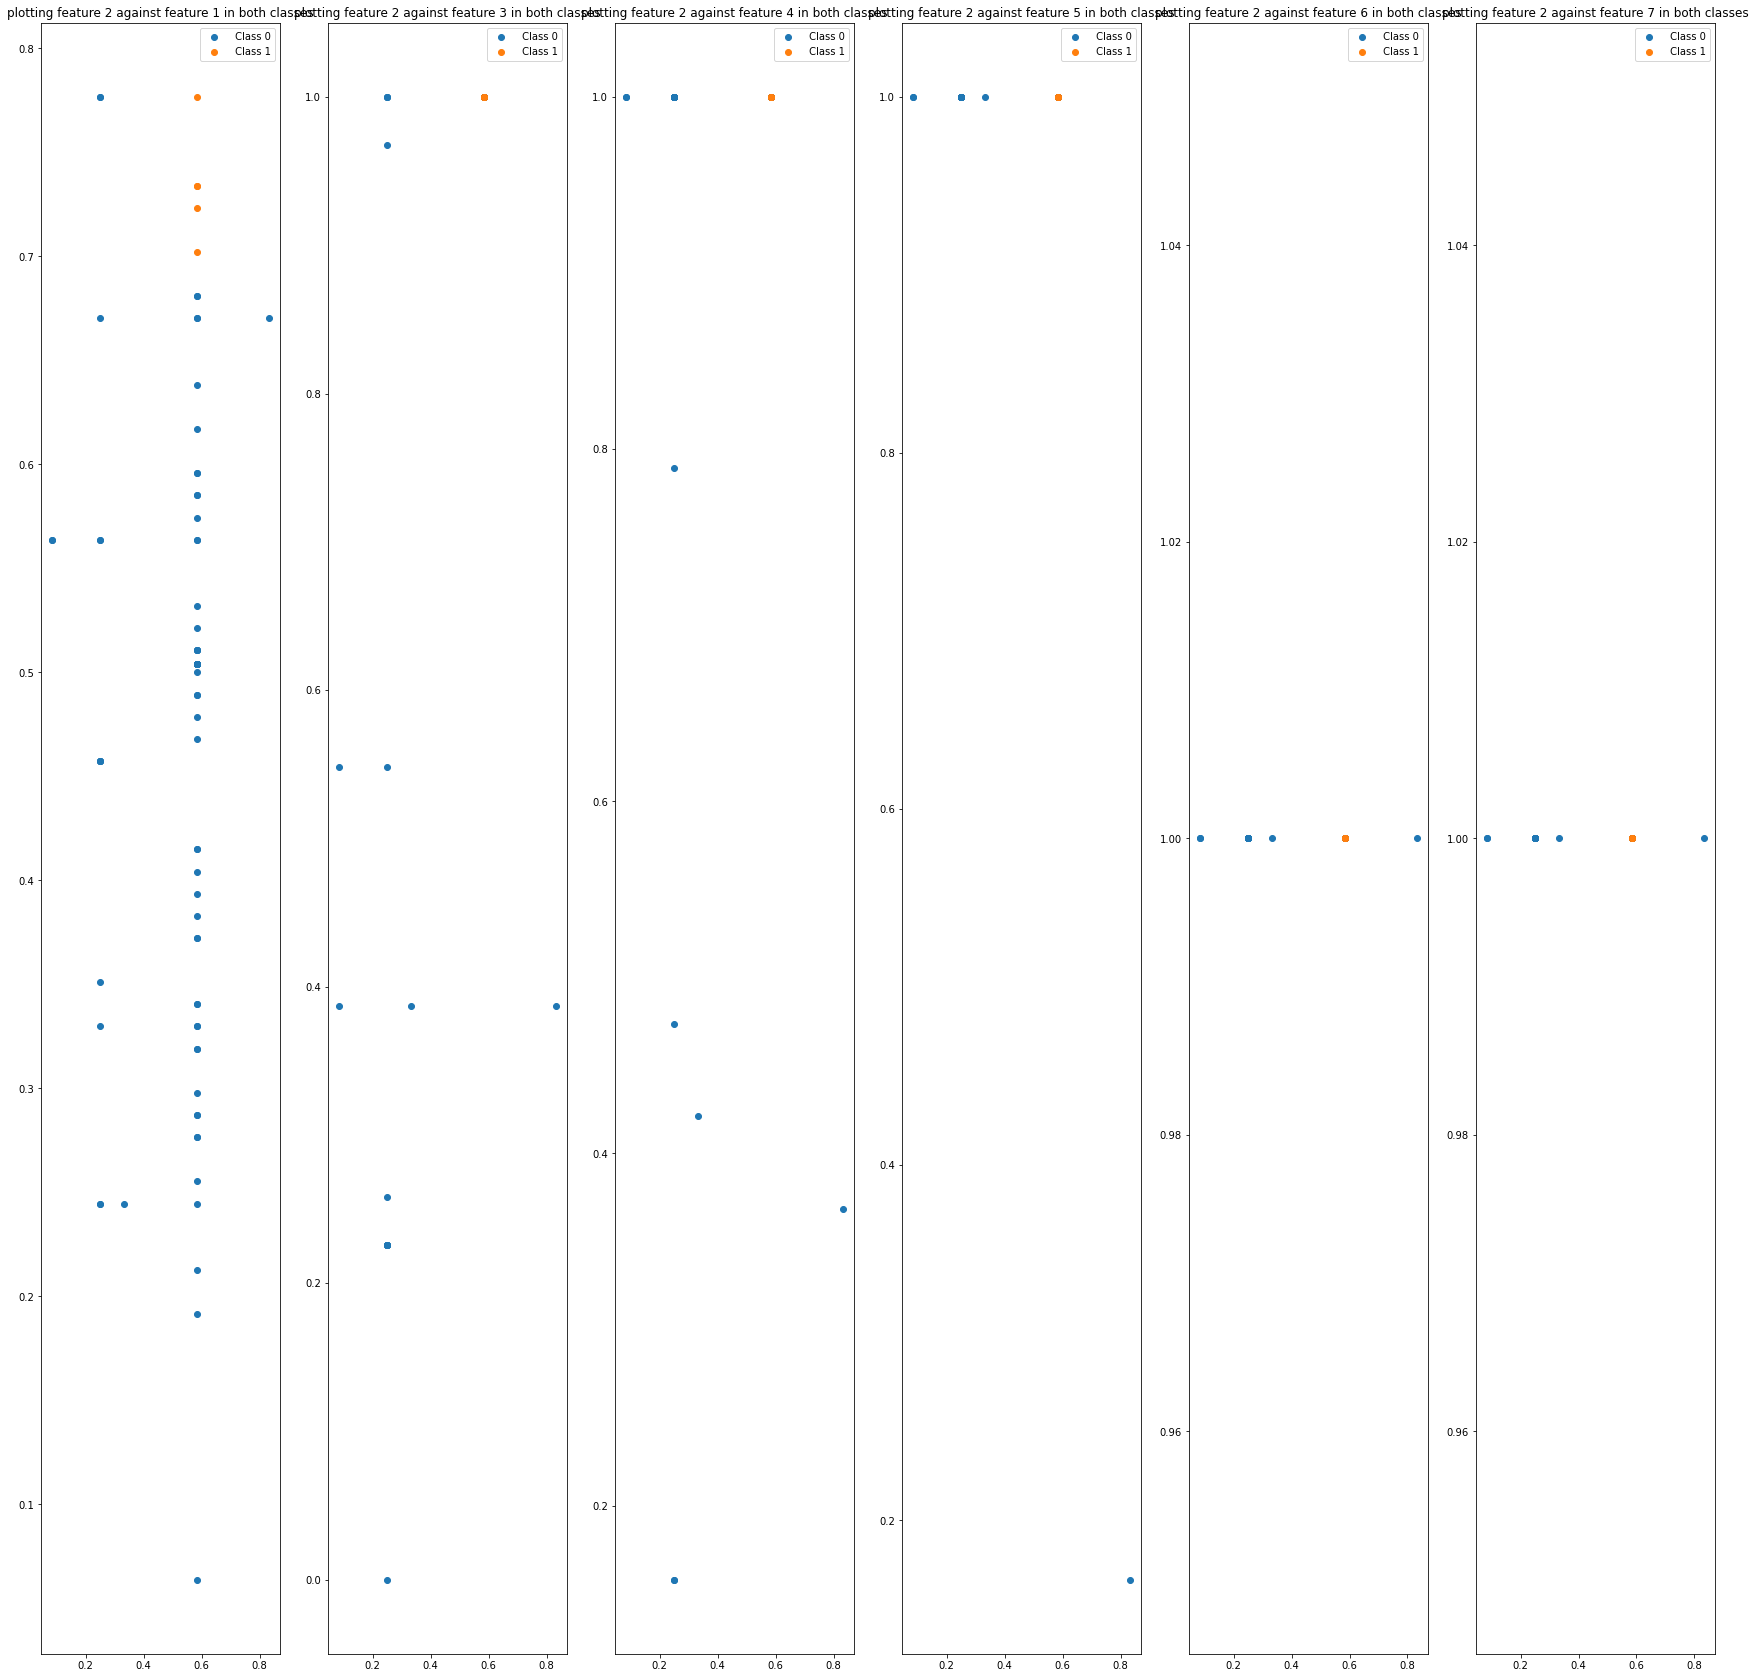

<Figure size 432x288 with 0 Axes>

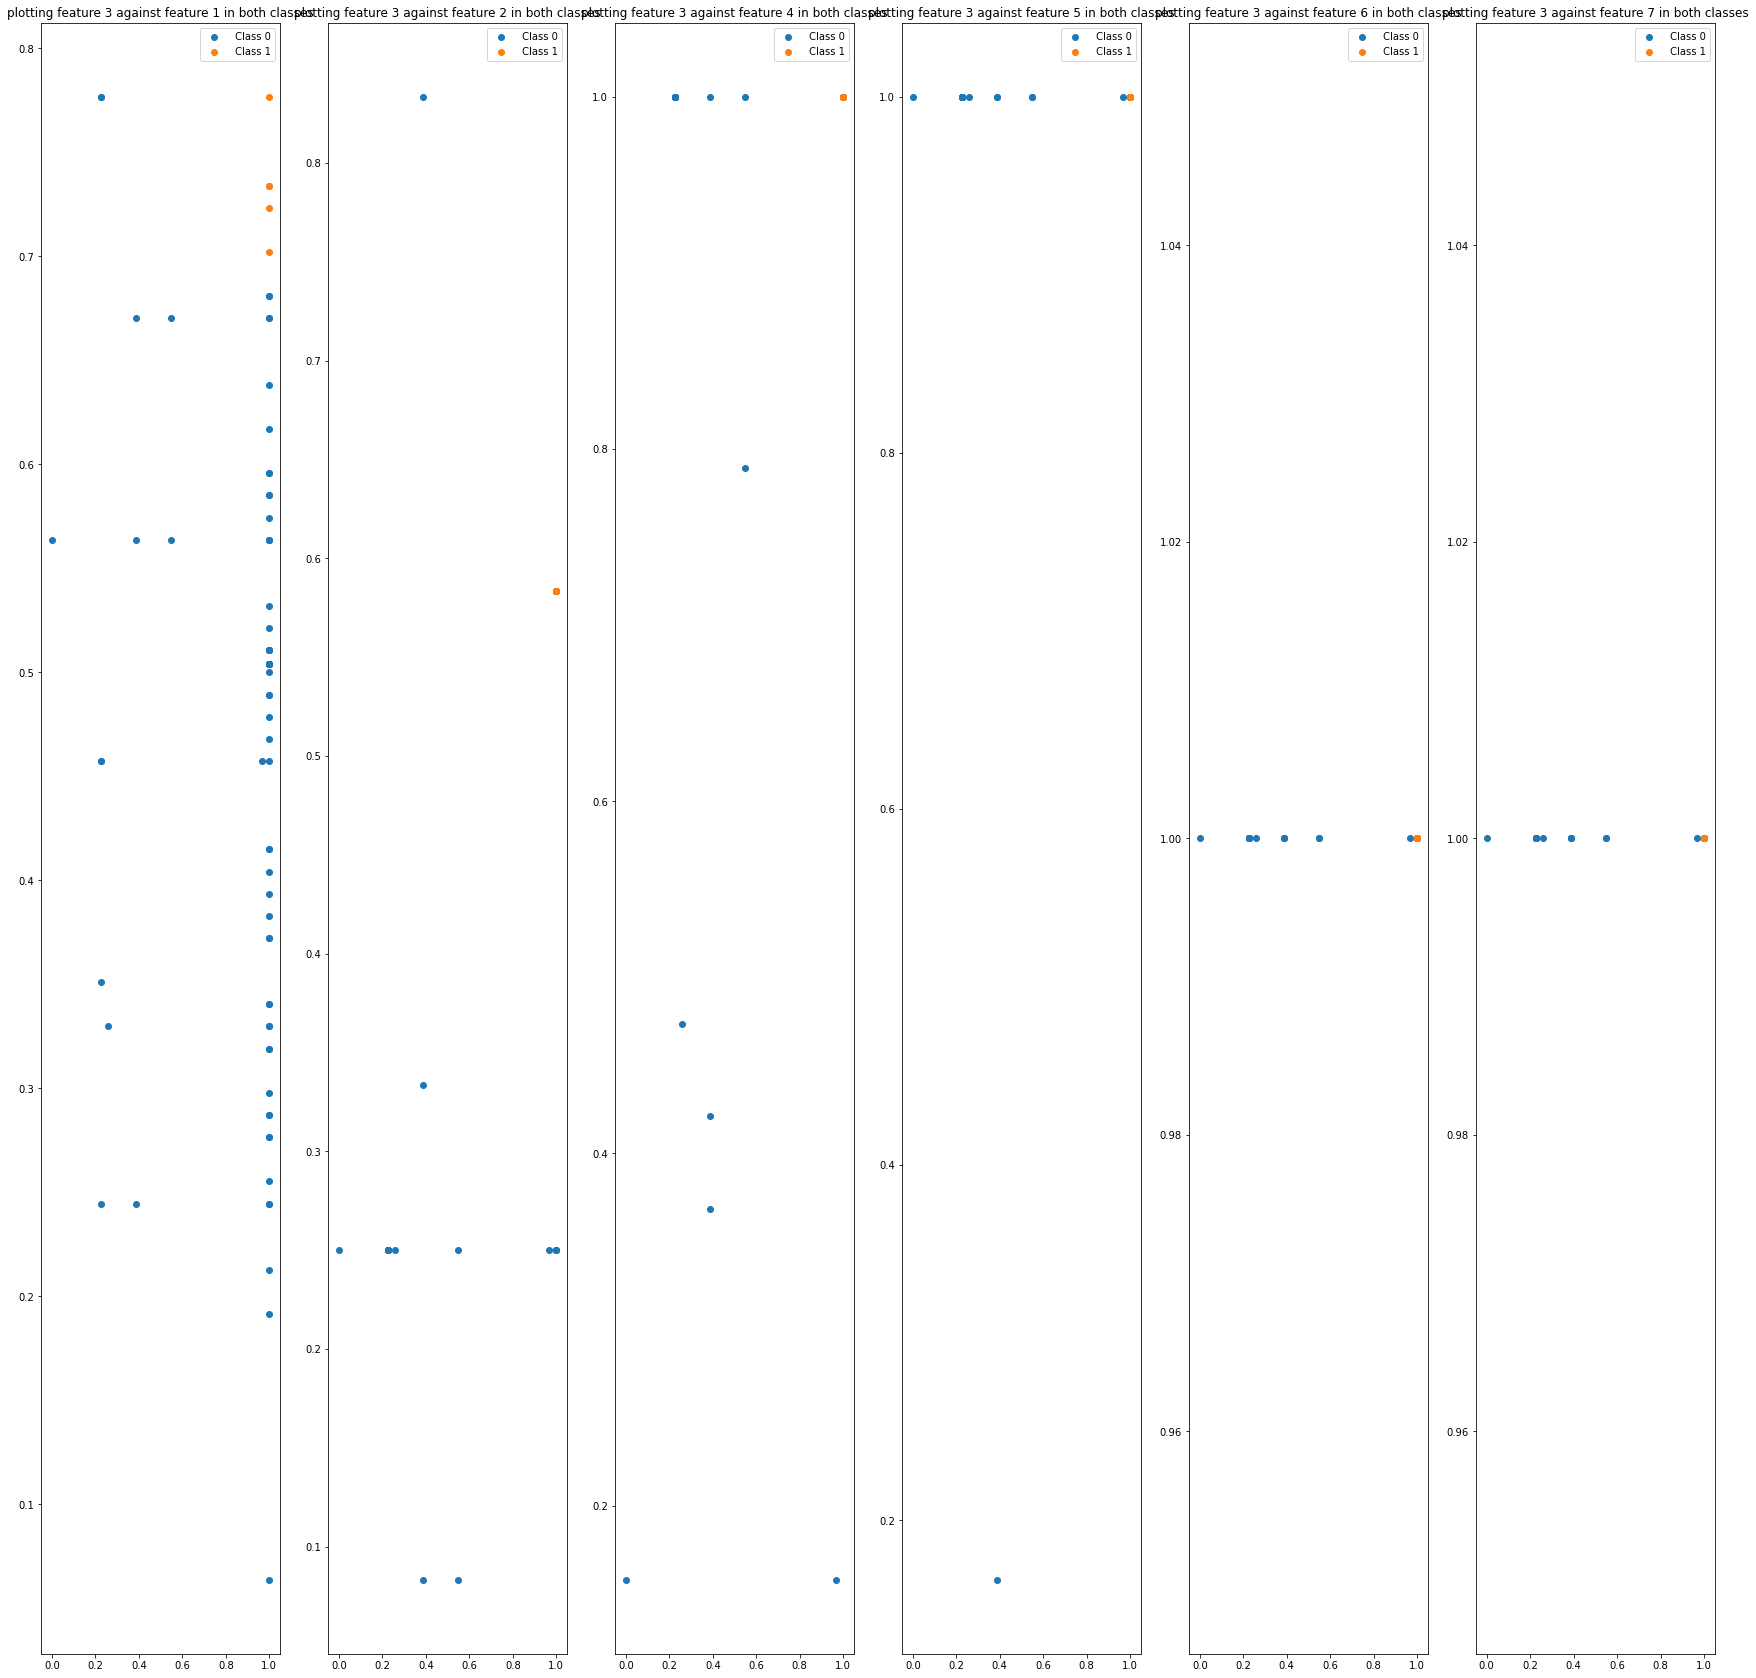

<Figure size 432x288 with 0 Axes>

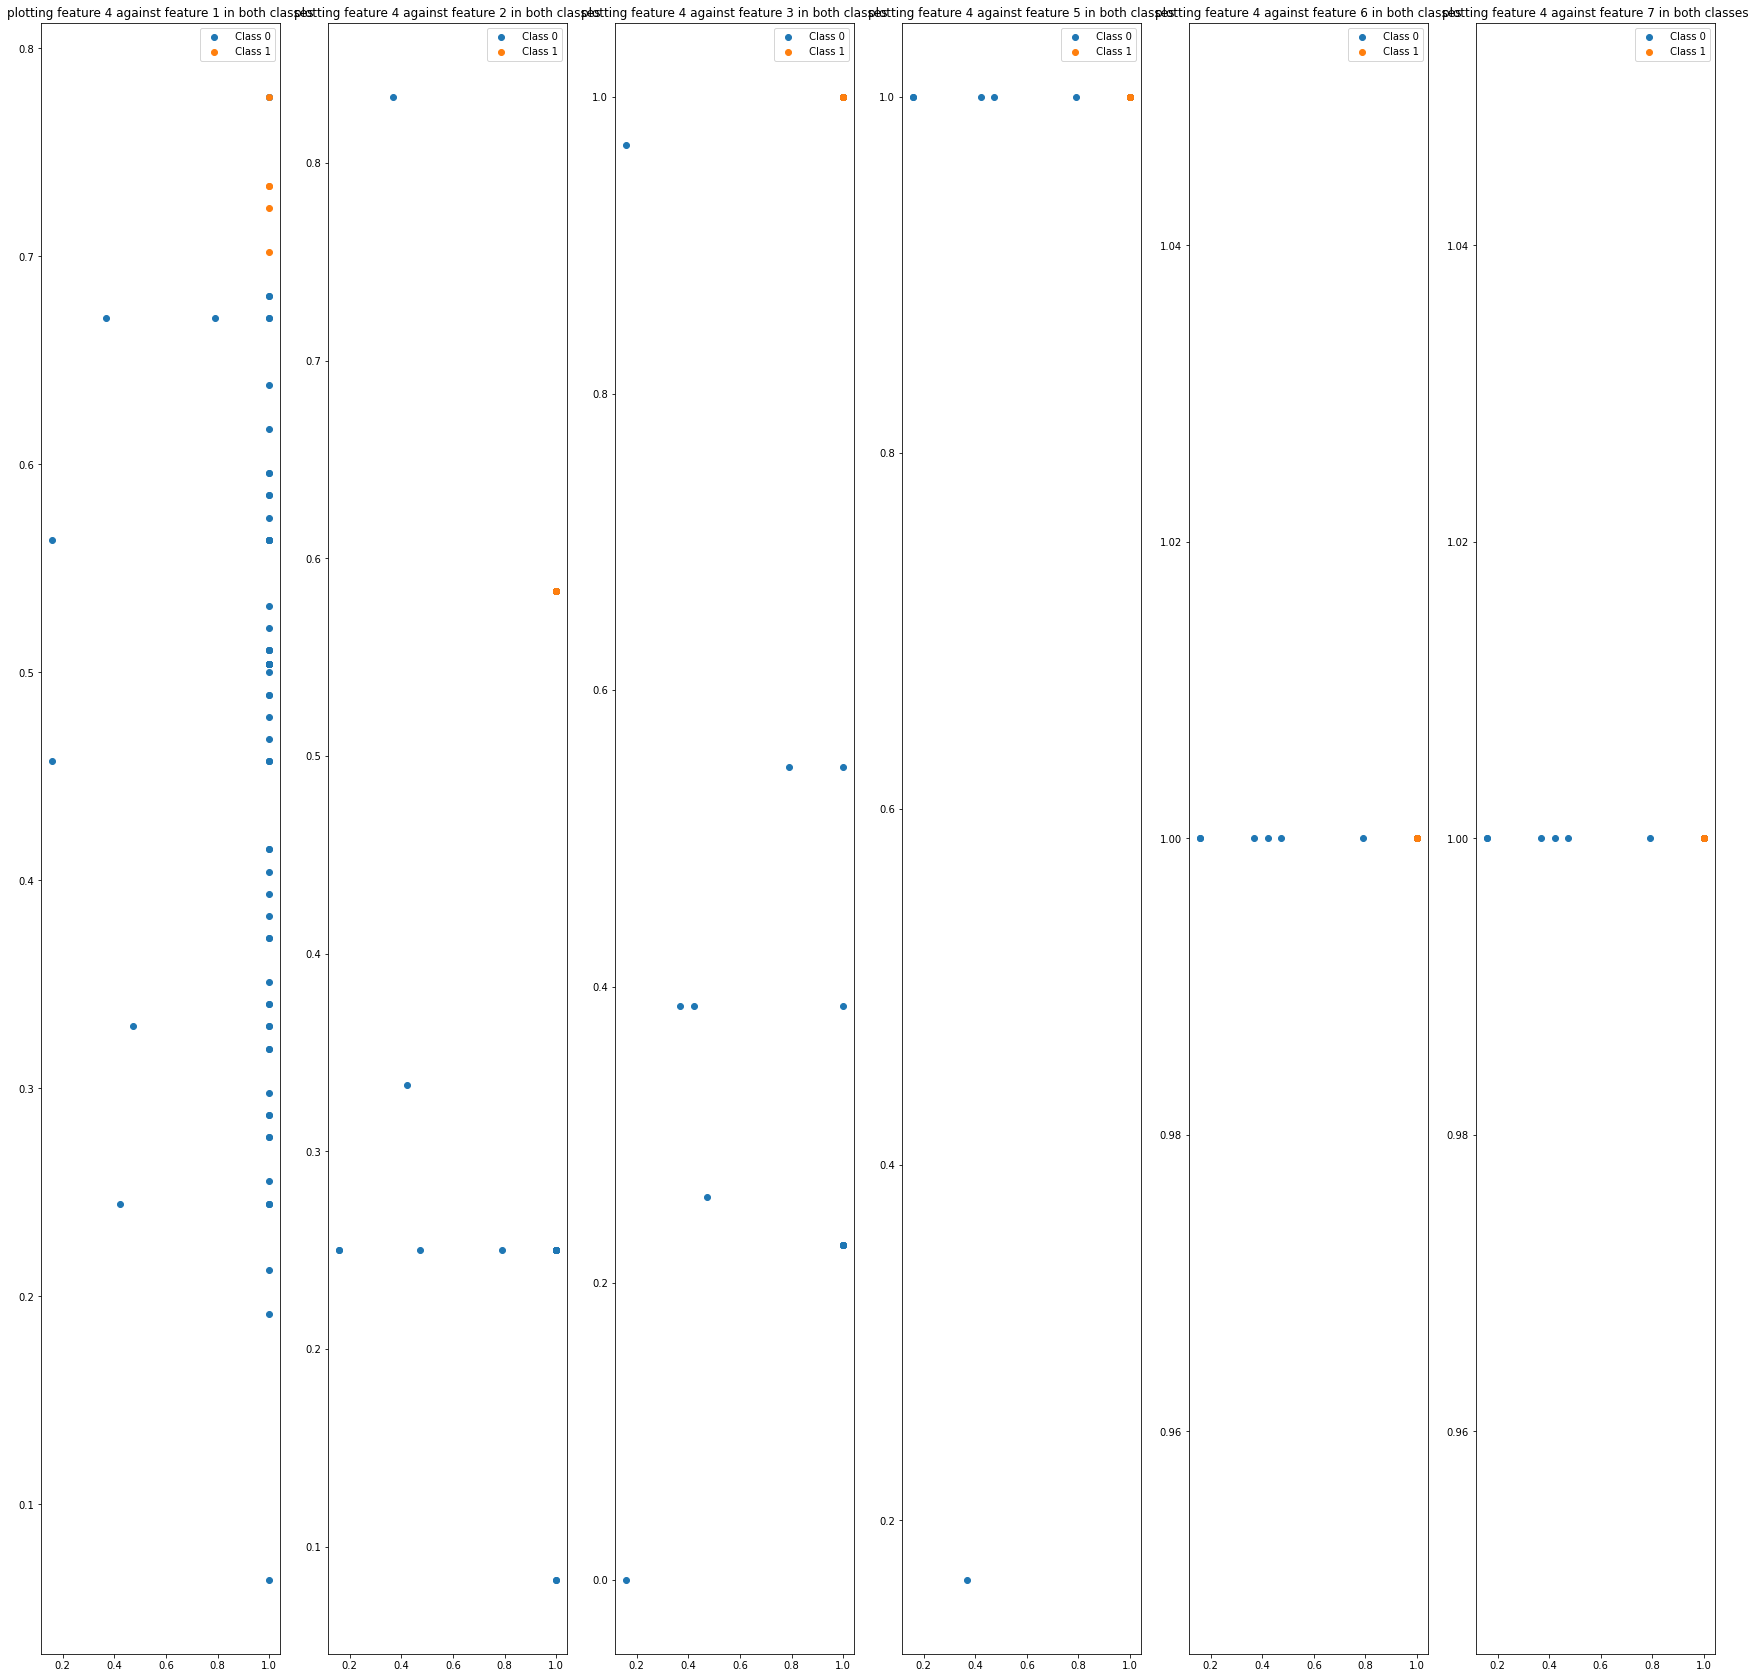

<Figure size 432x288 with 0 Axes>

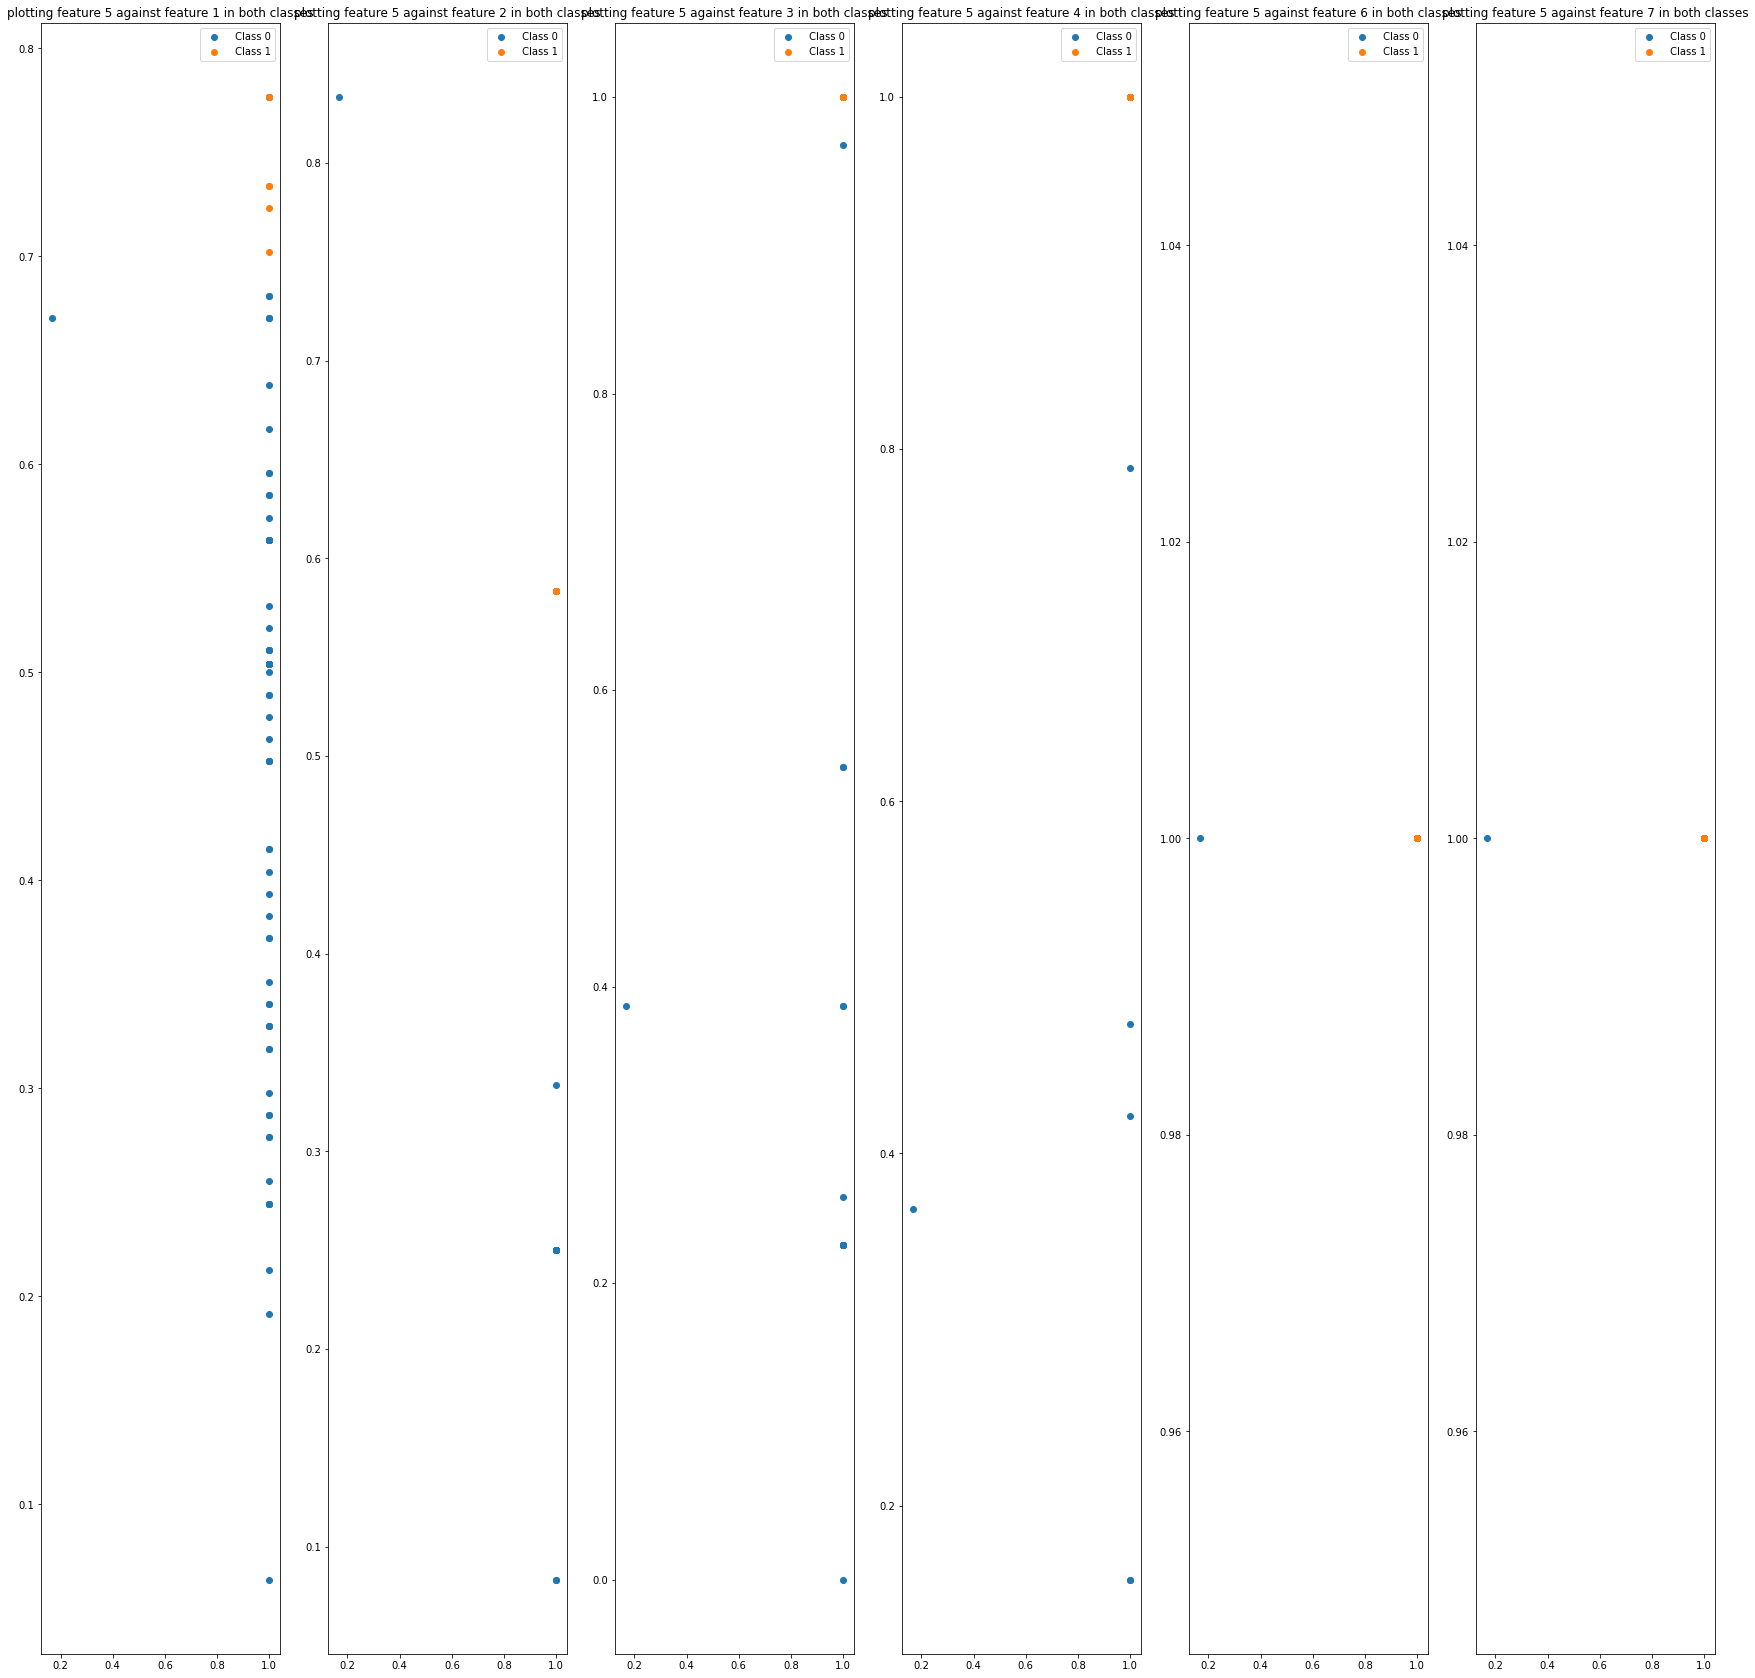

<Figure size 432x288 with 0 Axes>

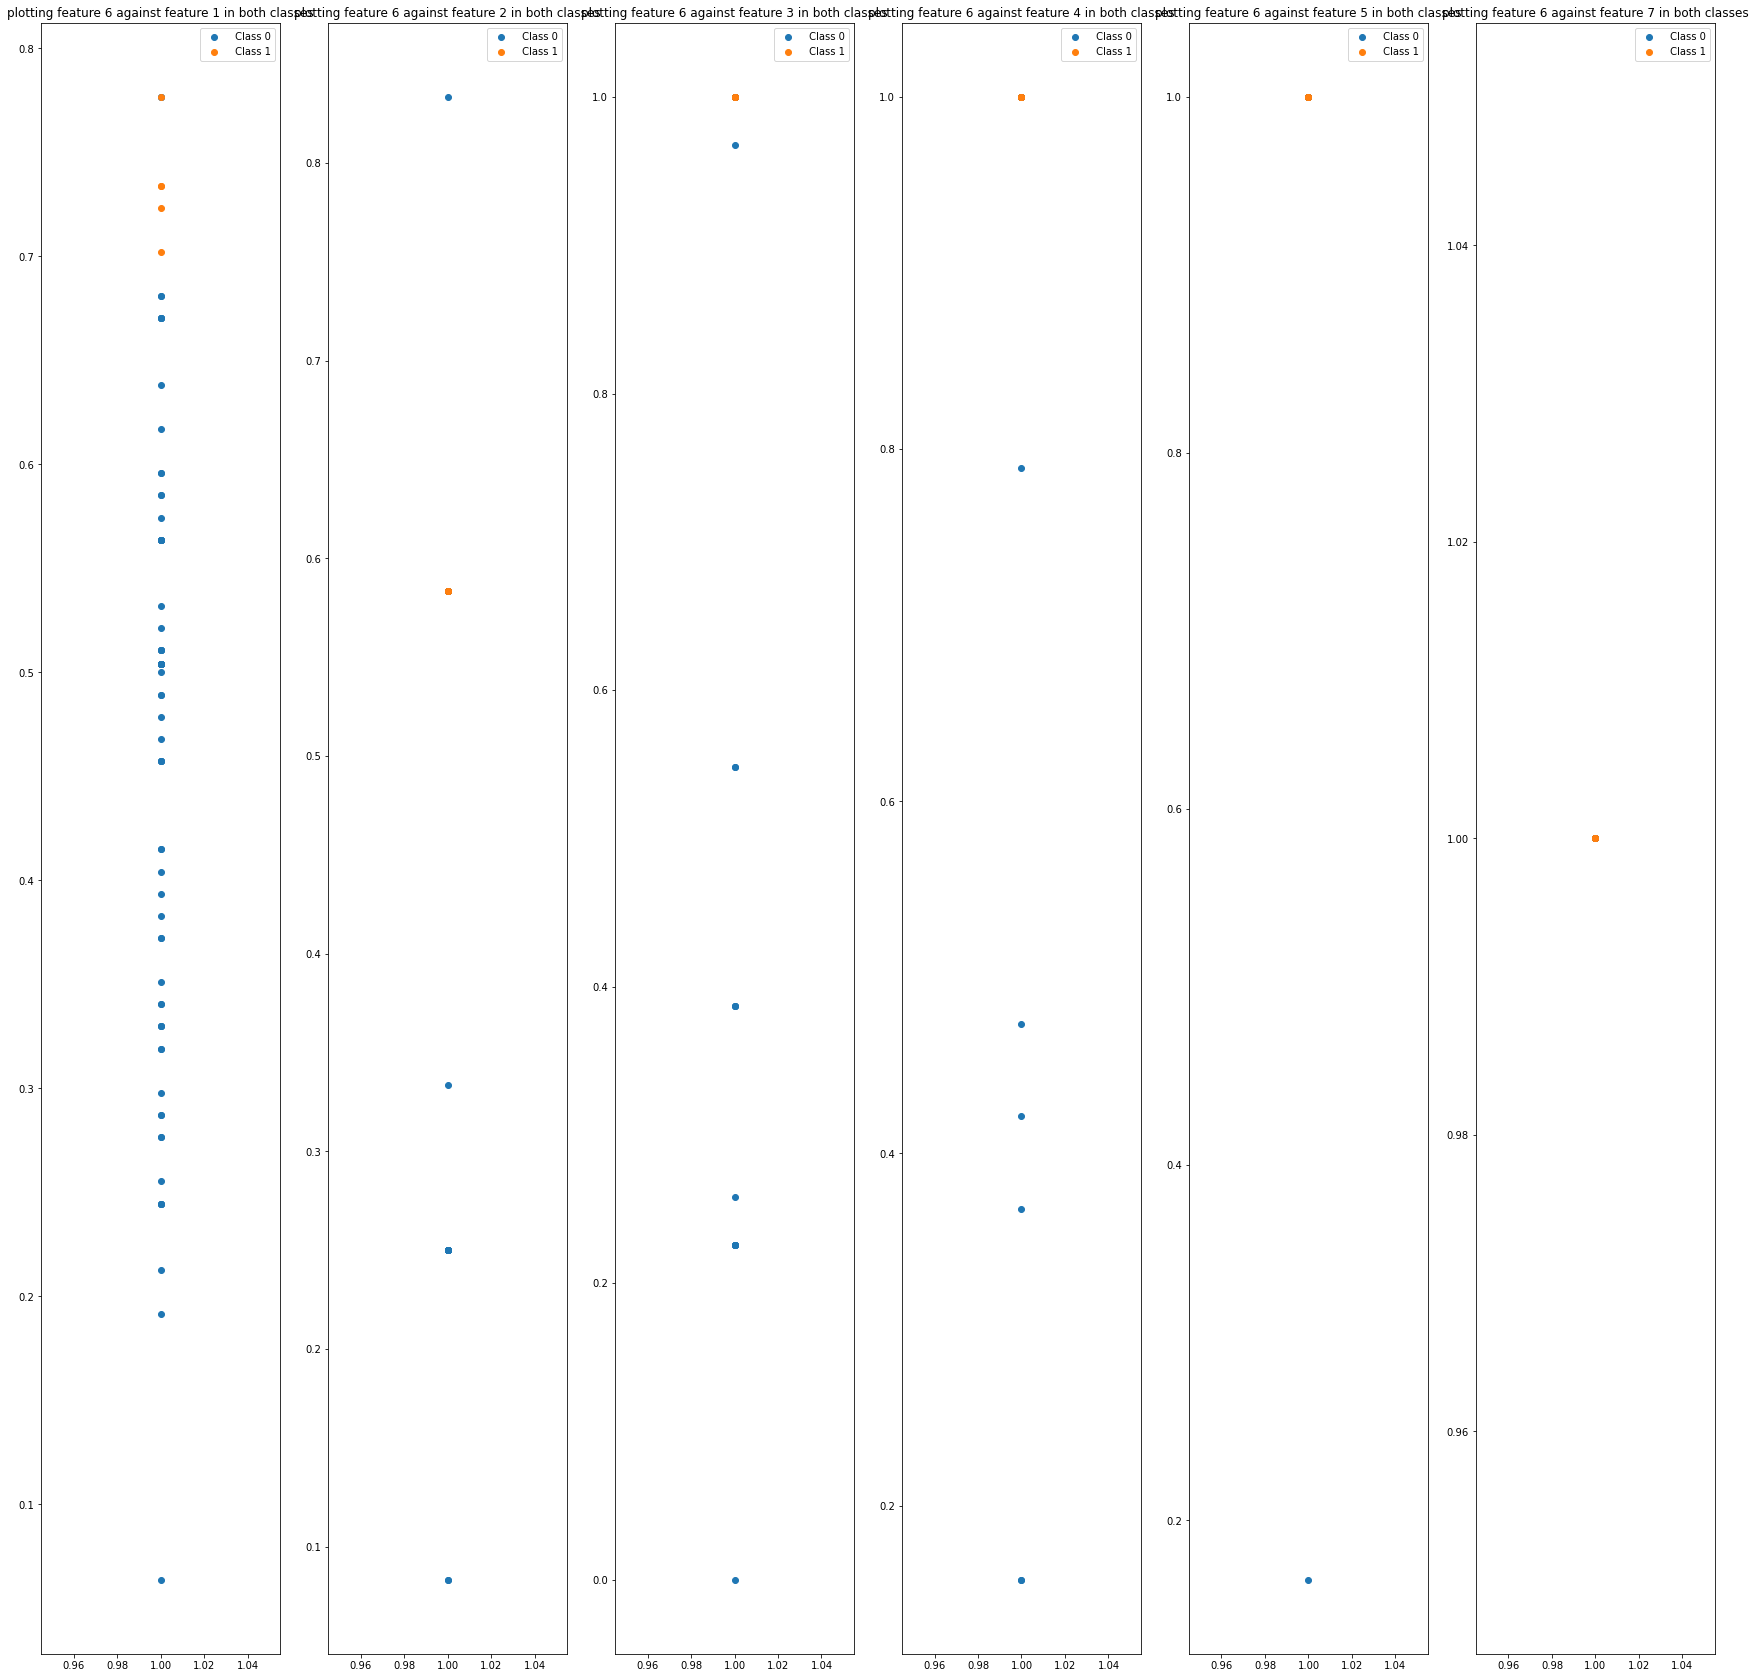

In [24]:
y_pred = classifier.predict(X_test)
print(y_pred)
scatter_plot_multidimensional_data(X_test,y_pred)
score(y_test, y_pred)

In [109]:
# x=[[1,2,3]]
# xt=[[0.5,4,5]]
# xtp=np.power(xt,2)
# xp=np.power(x,2)
# xs=np.subtract(x,xt)
# vals=np.sqrt(np.sum(np.power(np.subtract(x,xt),2)))
# print(vals)
# print(xs)
# print(xp)
# print(xtp)
#from operator import itemgetter
def KNN_implementation_singleelement(X_train,y_train,X_test,K):
    rows,cols=X_train.shape
    distances=list()
    for i in range(rows):
        d=np.sqrt(np.sum(np.power(np.subtract(X_train[i],X_test),2)))
        distances.append(d)
    #nearestkneigbors=dict(sorted(distances.items(), key =itemgetter(1), reverse = False)[:K])
    #distances=np.asarray(d)
    nnidx=sorted(range(len(distances)), key = lambda x: distances[x])[:K]
    #print("nearest indeces {}".format(nnidx[0]))
    nearestkneigbors=nnidx[:K]
    #print("nearest neighbors: {}".format(nearestkneigbors))
    #indexkeys=list(nearestkneigbors.keys())
    #print(indexkeys)
    #for i in range(len(indexkeys)):
        #print('labels {}'.format(y_train[indexkeys[i]]))
    #finding majority class
    majorityclass={}
    #making majority initially =0 for all classes 
    for i in range(int(y_train.max()+1)):
        majorityclass[i]=0 
    #print("number od nn is {}".format(len(nearestkneigbors)))
    for neighbor in nearestkneigbors:
        #print(y_train[i])
        #print(neighbor)
        idx=y_train[neighbor]
        majorityclass[int(idx)]+=1
        #return max(majorityclass,key= lambda x : majorityclass[x])
        return max(majorityclass.values())


def KNN_sequence(X_train,y_train,X_test,K):
    ypreds=list()
    rows,cols=X_test.shape
    for i in range(rows):
        ypreds.append(KNN_implementation_singleelement(X_train,y_train,X_test[i],K))
    return ypreds




In [110]:
y_pred =  KNN_sequence(X_train,y_train,X_valid,5)
print(y_valid[77])
xs=X_valid[77]
y_pred =  KNN_implementation_singleelement(X_train,y_train,xs,6)
print("ypred implemented {}".format(y_pred))
#print(len(y_pred))
classifier = KNeighborsClassifier(n_neighbors = 100)
classifier.fit(X_train, y_train)

y_pred2 = classifier.predict((np.transpose(xs[:,np.newaxis])))
print("ypred basic {}".format(y_pred2))
#print(len(y_pred))

#print(np.subtract(y_pred,y_pred2))
def pick_k_implemented(min: int = 1, maxnum: int = 10, visualize=False):
    min = min if (min % 2 == 1) else (min + 1)
    acc = {}
    for k in range(min, maxnum, 2):
        y_pred =  KNN_sequence(X_train,y_train,X_valid,k)
        acc[k]= accuracy_score(y_valid, y_pred)
    print(acc)
    if visualize:
        sns.lineplot(acc.keys(), acc.values())
        plt.title("Accuracy vs. K")
        plt.xlabel("K neighbours")
        plt.ylabel("Accuracy")
       
    return max(acc,key= lambda x : acc[x]) 

1.0
ypred implemented 1
ypred basic [0.]


{1: 0.9069767441860465, 3: 0.9069767441860465, 5: 0.9069767441860465, 7: 0.9069767441860465, 9: 0.9069767441860465, 11: 0.9069767441860465, 13: 0.9069767441860465}


C:\Users\omark\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


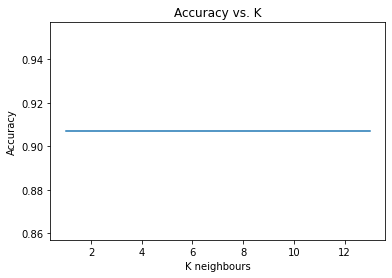

In [69]:
k_neighbors = pick_k_implemented(min=1, maxnum=15, visualize=True)